# Dane techniczne sprzętu

Obliczenia zostały wykonane na komputerze o następujących parametrach:

- Procesor: AMD Ryzen $7$ $4700$U ($8$ rdzeni, $8$ wątków),

- Pamięć RAM: $16$ GB $3200$ MHz

# Biblioteki

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from sympy import Symbol, lambdify
from time import time
from tabulate import tabulate
import random
from copy import copy

In [2]:
sns.set(rc={"figure.dpi": 200, 'savefig.dpi': 200})

# Pomocnicze funkcje

## Obliczenia

### Budowanie macierzy wypełnionej zgodnie ze wzorem

In [3]:
def create_matrix(fn, n, m, dtype=np.float64):
    A = np.empty((n, m), dtype)
    
    for i in range(n):
        for j in range(m):
            A[i, j] = fn(i + 1, j + 1)
            
    return A

### Tworzenie wektorów

#### Tworzenie wektora wypełnionego wartościami zgodnie z zadaną funkcją

In [4]:
def create_vector(fn, n, dtype=np.float64):
    return np.array([fn(i) for i in range(n)], dtype)

### Pomiar czasu wykonywania kodu

#### Dekorator, pozwalający na pomiar czasu wykonania kodu

In [5]:
def print_duration(sec):
    t = int(sec)
    ms = int((sec - t) * 1000)
    s = t % 60
    t //= 60
    m = t % 60
    t //= 60
    print(f'Total execution time: {t:>02}:{m:>02}:{s:>02}.{ms:<03}\n')

def timed(*, save_fn=None, save_dict=None):
    def decorator(fn):
        def inner(*args, **kwargs):
            start_time = time()
            res = fn(*args, **kwargs)
            duration = time() - start_time
    
            if save_dict is not None and save_fn: 
                save_dict[save_fn(*args, **kwargs)] = duration
            return res
        
        return inner
    return decorator

### Porównywanie wartości obliczonego wektora do rzeczywistego

#### Norma maksimum

In [6]:
max_err = lambda v1, v2: max(abs(v1 - v2))

# Zadanie 1

## Opis problemu

Elementy macierzy $A$ dane są wzorem:

$
\begin{cases} 
    a_{1, j} = 1 \\ 
    a_{i, j} = \frac{1}{i \hspace{5px} + \hspace{5px} j \hspace{5px} - \hspace{5px} 1}, & dla \hspace{10px} i \neq 1 \\
\end{cases}
$

gdzie $i, j \in \{1, 2, ..., n\}$

## Tworzenie macierzy

### Implementacja funkcji, zgodnie z którą wypełnione są wartości macierzy

In [7]:
def fn(i: int, j: int) -> float:
    if i == 1:
        return 1
    return 1 / (i + j - 1)

###### Test

In [8]:
n = 4
A = create_matrix(fn, n, n)
A

array([[1.        , 1.        , 1.        , 1.        ],
       [0.5       , 0.33333333, 0.25      , 0.2       ],
       [0.33333333, 0.25      , 0.2       , 0.16666667],
       [0.25      , 0.2       , 0.16666667, 0.14285714]])

## Implementacja algorytmu eliminacji Gaussa

In [9]:
times = {}

In [10]:
@timed(
    save_fn=lambda A, *args, **kwargs: len(A),
    save_dict=times
)
def gauss(A: np.ndarray, B: np.ndarray, prec=np.float64) -> np.ndarray:
    n = len(A)
    A = np.array(A, prec)
    B = np.array(B, prec)
    X = np.zeros(n, prec)
    
    n = len(A)
    for k in range(n - 1):
        for i in range(k + 1, n):
            if A[i, k] == 0: continue
            factor = A[k, k] / A[i, k]
            for j in range(k, n):
                A[i, j] = A[k, j] - A[i, j] * factor
            B[i] = B[k] - B[i] * factor
                
    X[n - 1] = B[n - 1] / A[n - 1, n - 1]
    for i in range(n - 2, -1, -1):
        sum_ax = 0
        for j in range(i + 1, n):
            sum_ax += A[i, j] * X[j]
        X[i] = (B[i] - sum_ax) / A[i, i]
        
    return X

###### Test

In [11]:
random.seed(0)

n = 8
A = create_matrix(fn, n, n)
X = create_vector(lambda i: 1 if random.random() > .5 else -1, n)
B = A @ X
X_res = gauss(A, B)
X, X_res

(array([ 1.,  1., -1., -1.,  1., -1.,  1., -1.]),
 array([ 1.        ,  1.        , -1.00000002, -0.99999994,  0.99999986,
        -0.99999984,  0.9999999 , -0.99999998]))

## Rozwiązanie zadania

### Pomocnicza funkcja

In [12]:
def calculate_helper(ns, prec, seed=0, err_calc_fn=max_err, log_every=10):
    results = {}
    expected = {}
    errors = {}
    
    for i, n in enumerate(ns):
        if i and not i % log_every: 
            print(f'Obliczono {i} układów równań')
            
        A = create_matrix(fn, n, n, prec)
        expected[n] = X = create_vector(lambda i: 1 if i % 2 else -1, n, prec)
        # Calculate the B vector based on the known value of X
        B = A @ X
        # Calculate the X vector bsed on the A nad B matrix values
        results[n] = X_calc = gauss(A, B, prec)
        # Calculate errors using the specified error calculationg function
        errors[n] = err_calc_fn(X, X_calc)
        
    return results, expected, errors

### Obliczenia dla dwóch różnych precyzji (float32 i float64)

In [13]:
@timed(
    save_fn=lambda *args, **kwargs: 'total',
    save_dict=times
)
def calculate(ns, precs):
    results = {}
    
    for name, prec in precs.items():
        print(f'{"=" * 10} {name} {"=" * 10}')
        res, expected, errors = calculate_helper(ns, prec, log_every=25)
        results[name] = {
            'results': res,
            'expected': expected,
            'errors': errors,
            'times': copy(times)
        }
        print()
    
    return results

In [14]:
ns = range(2, 201)
precs = {
    'float32': np.float32, 
    'float64': np.float64
}
results = calculate(ns, precs)
print_duration(times['total'])

========== float32 ==========
Obliczono 25 układów równań
Obliczono 50 układów równań
Obliczono 75 układów równań
Obliczono 100 układów równań
Obliczono 125 układów równań
Obliczono 150 układów równań
Obliczono 175 układów równań

========== float64 ==========
Obliczono 25 układów równań
Obliczono 50 układów równań
Obliczono 75 układów równań
Obliczono 100 układów równań
Obliczono 125 układów równań
Obliczono 150 układów równań
Obliczono 175 układów równań

Total execution time: 00:02:33.712



### Wykresy

#### Pomocnicza funkcja

In [15]:
def scatter(results, attr, label, ylabel, scale=None, ns=None):
    err32 = results['float32'][attr]
    err64 = results['float64'][attr]
    
    if ns is not None:
        err32 = {i: err32[i] for i in ns}
        err64 = {i: err64[i] for i in ns}

    fig, ax = plt.subplots(figsize=(15, 7.5))
    if scale: ax.set_yscale(scale)
    plt.scatter(x=err32.keys(), y=err32.values(), c='#EA6A00', label='float32')
    plt.scatter(x=err64.keys(), y=err64.values(), c='#008C8C', label='float64')
    plt.title(label)
    plt.xlabel('wartość n')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

#### Błędy obliczeń

##### Skala liniowa

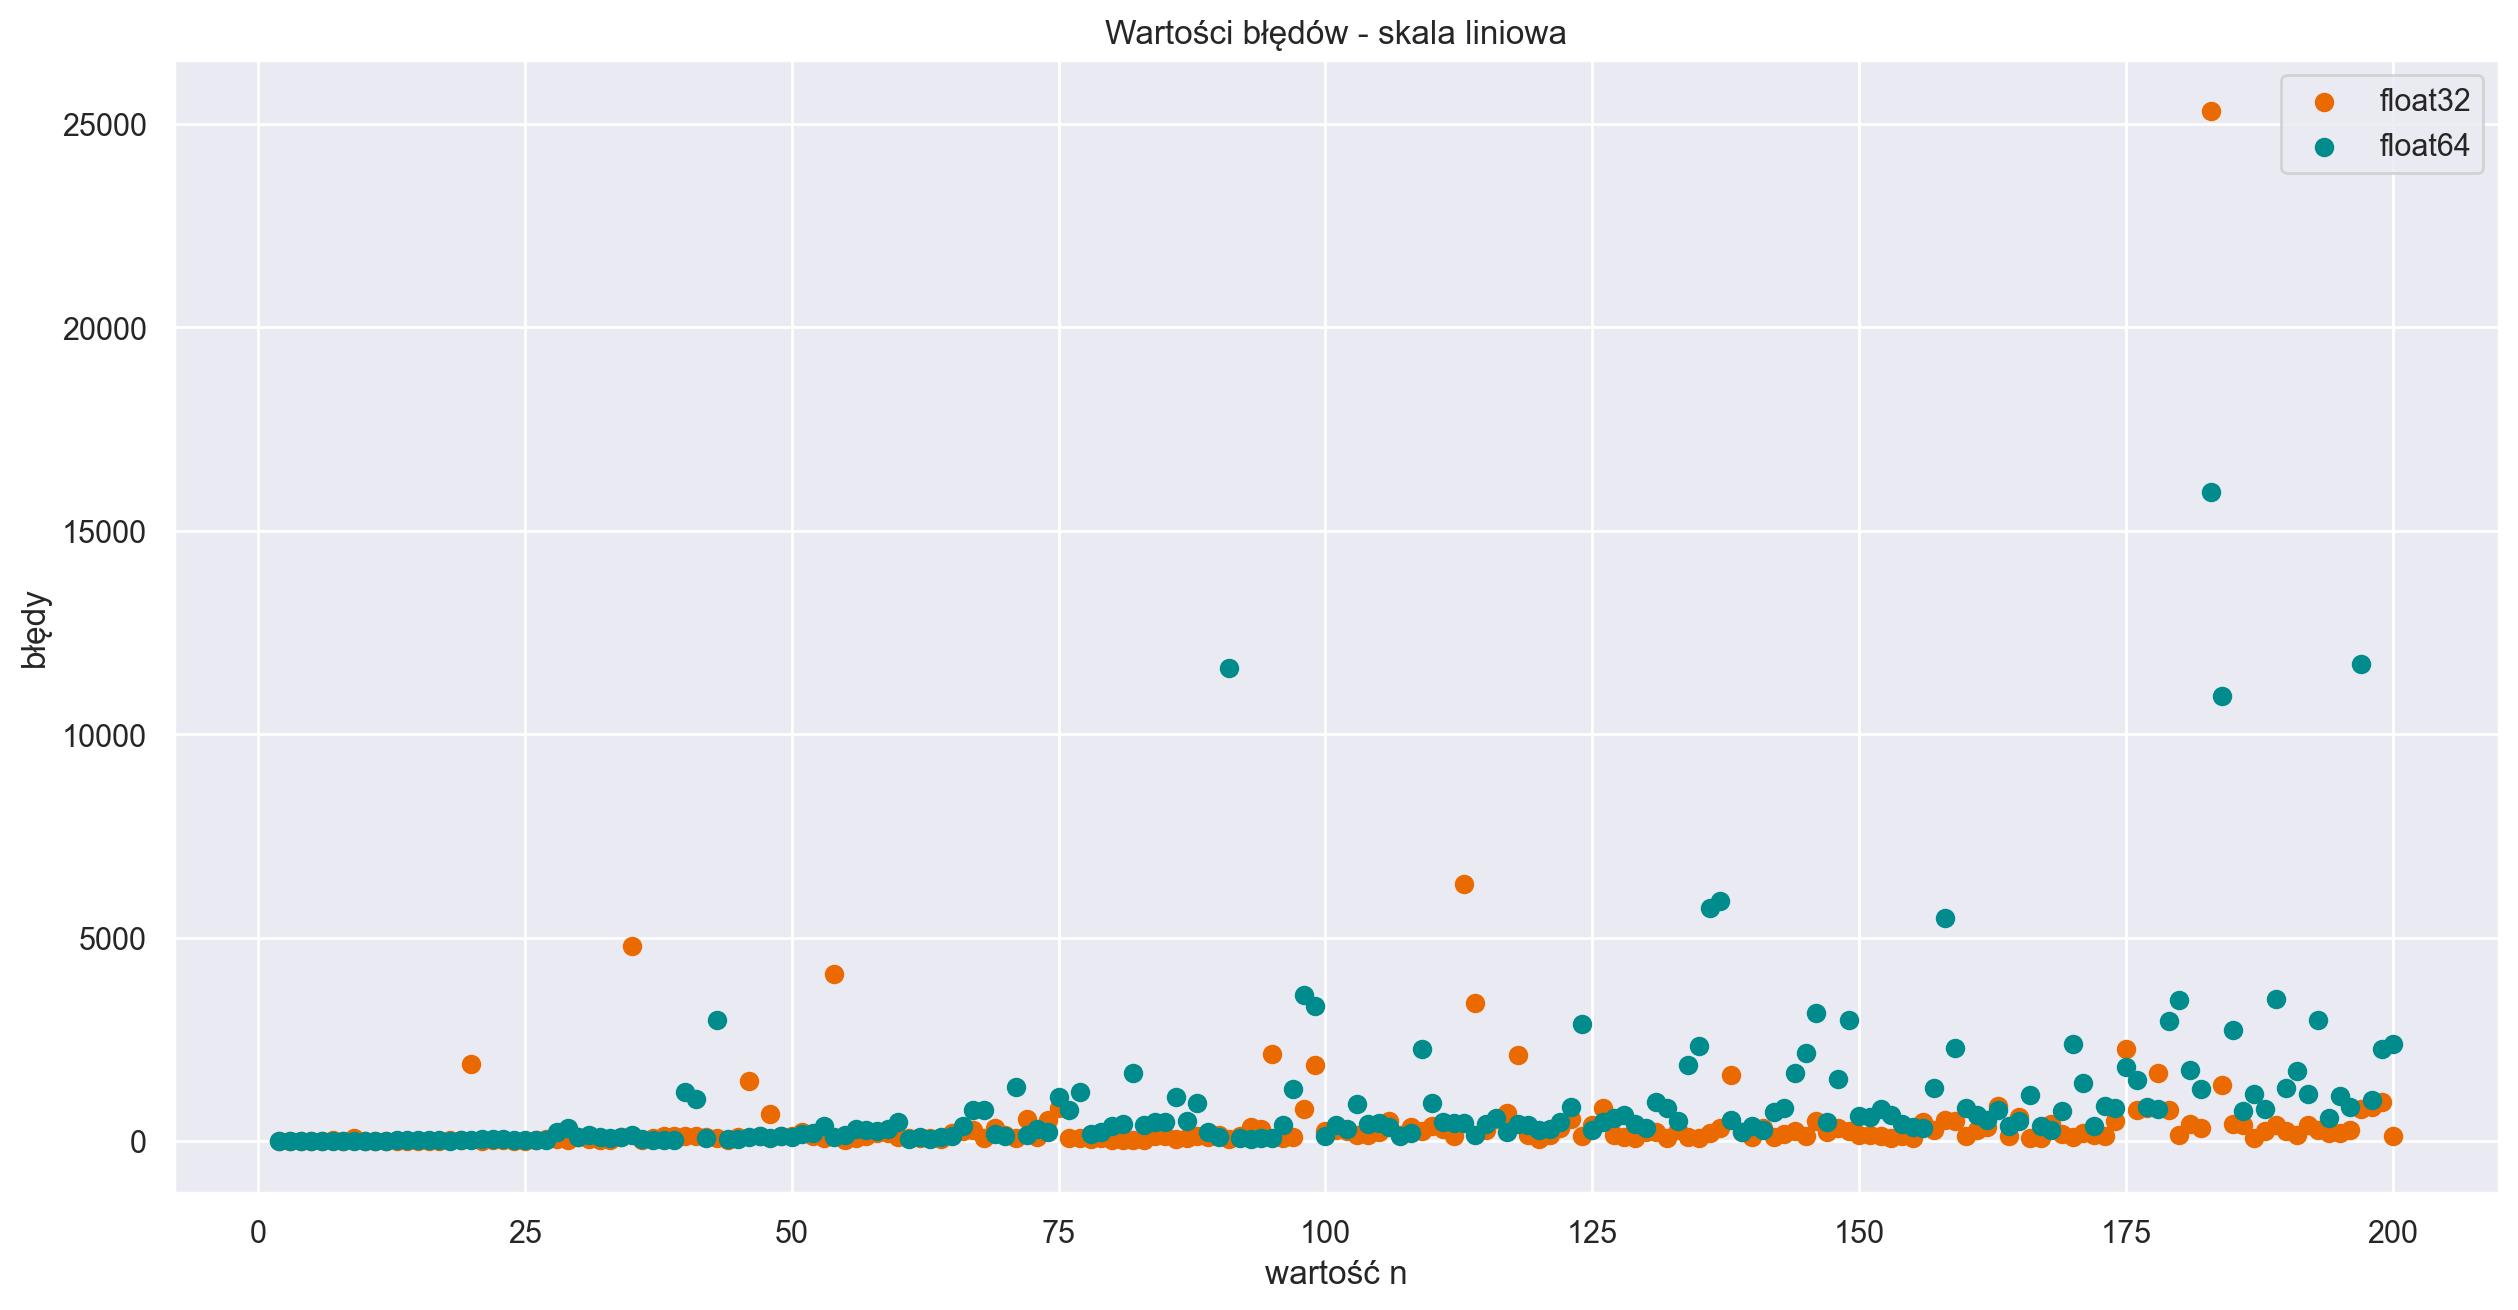

In [16]:
scatter(results, 'errors', 'Wartości błędów - skala liniowa', 'błędy')

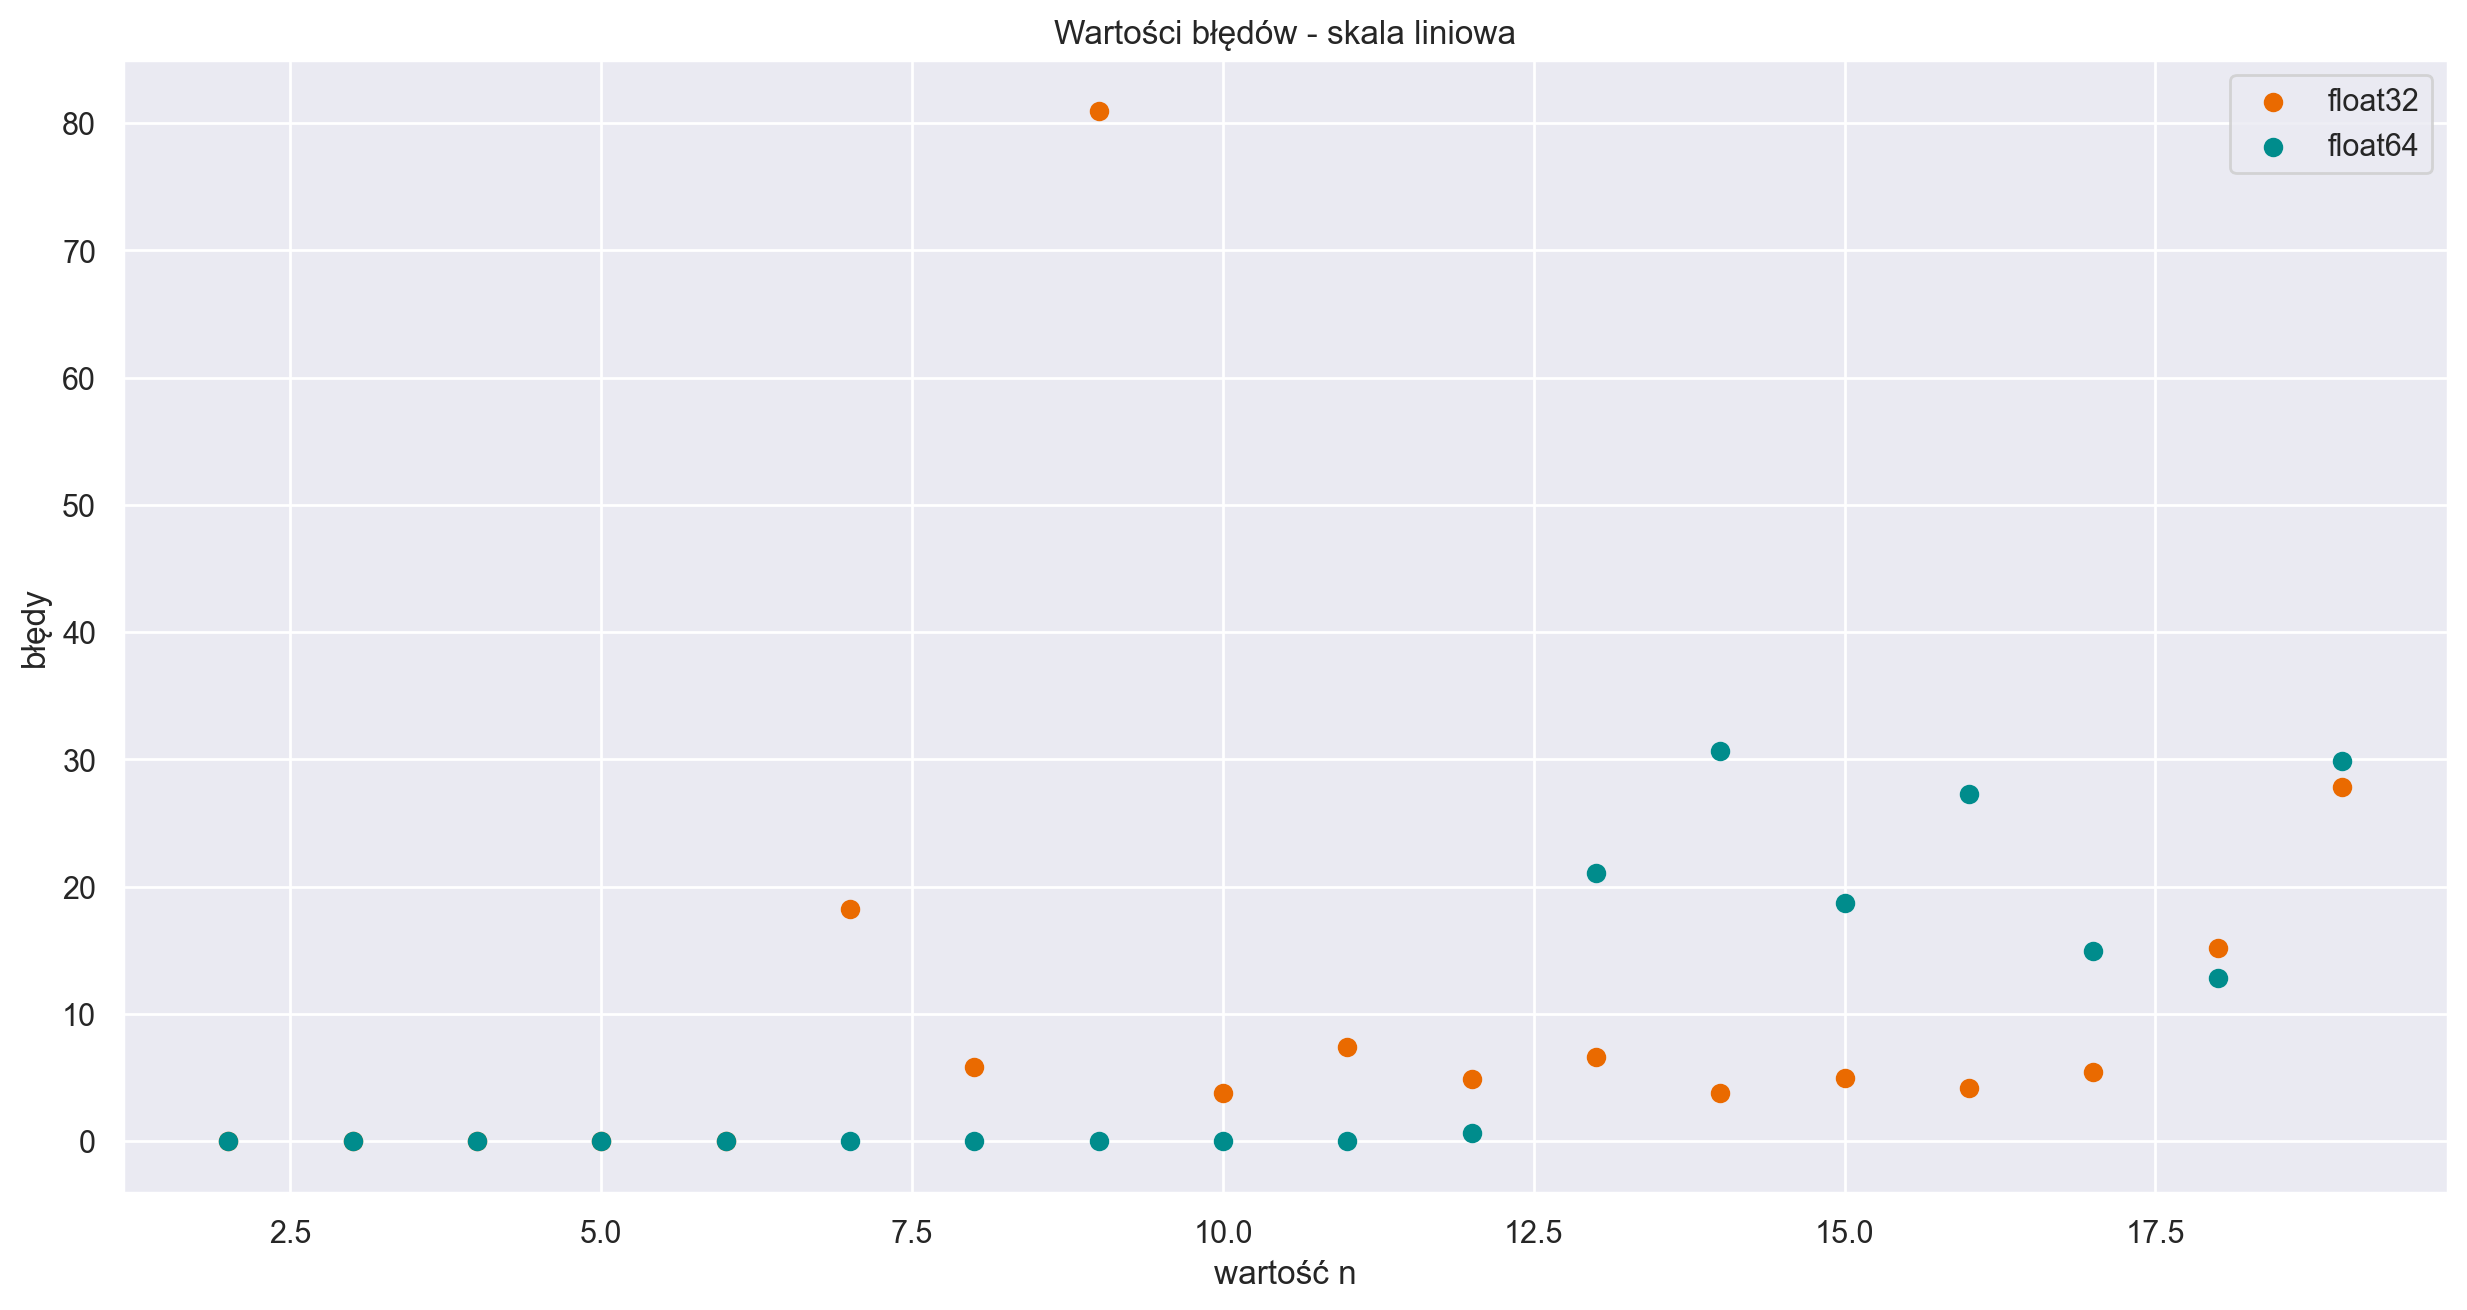

In [17]:
scatter(results, 'errors', 'Wartości błędów - skala liniowa', 'błędy', ns=list(range(2, 20)))

##### Skala logarytmiczna

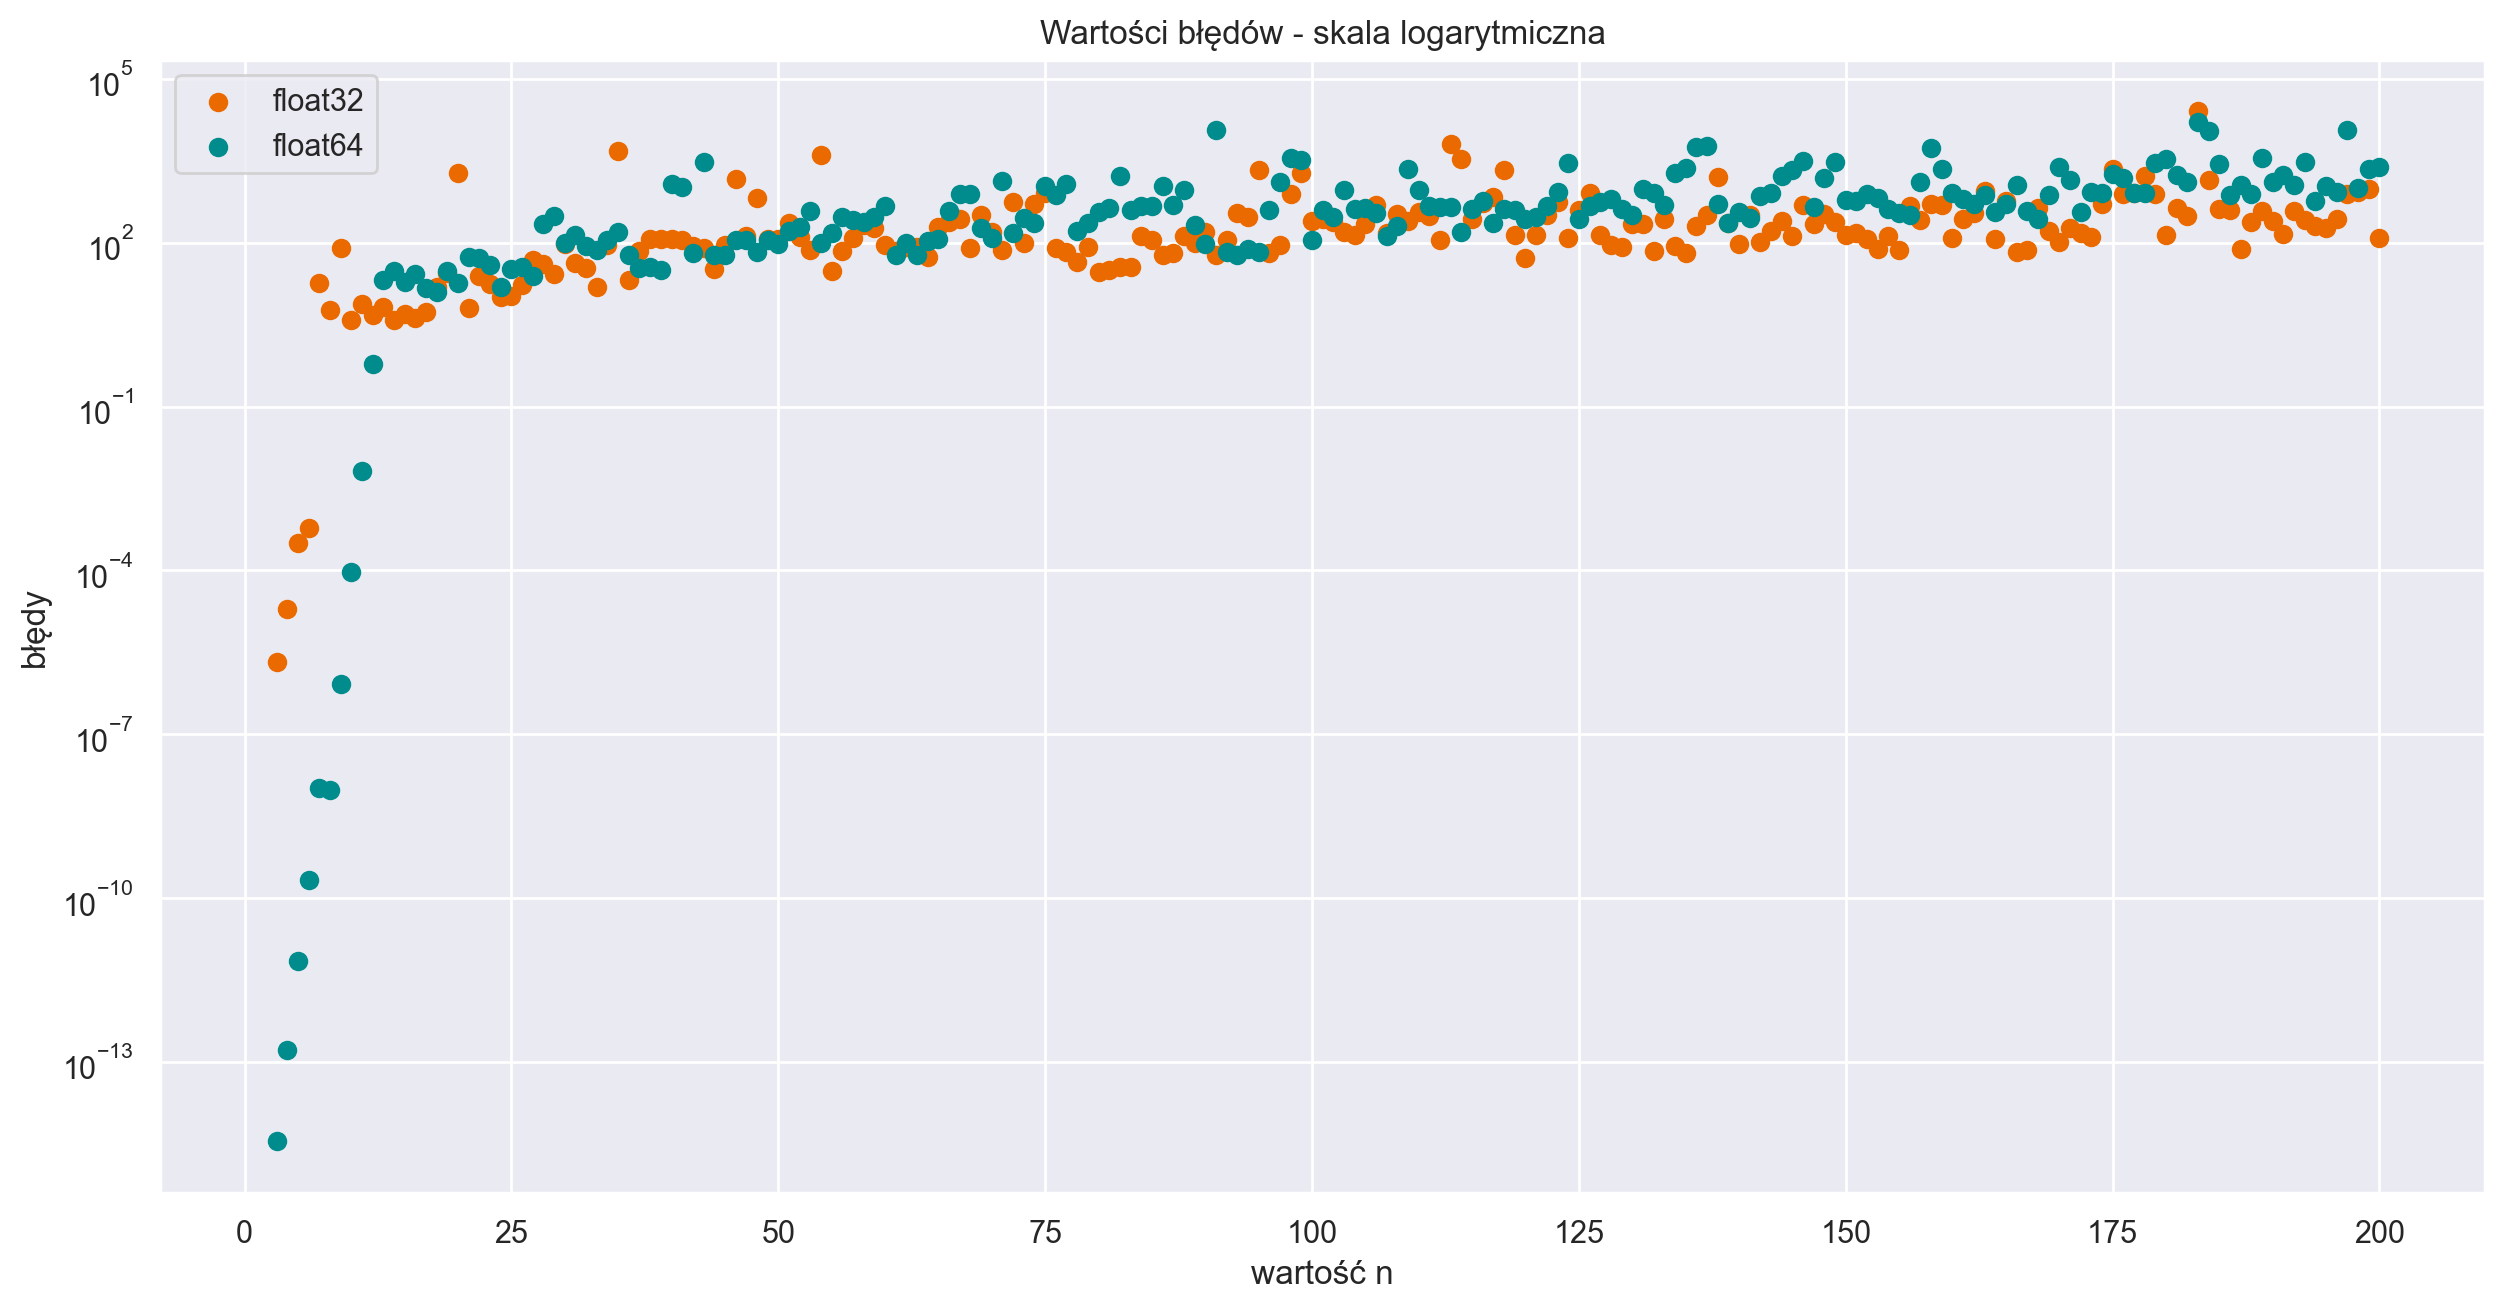

In [18]:
scatter(results, 'errors', 'Wartości błędów - skala logarytmiczna', 'błędy', 'log')

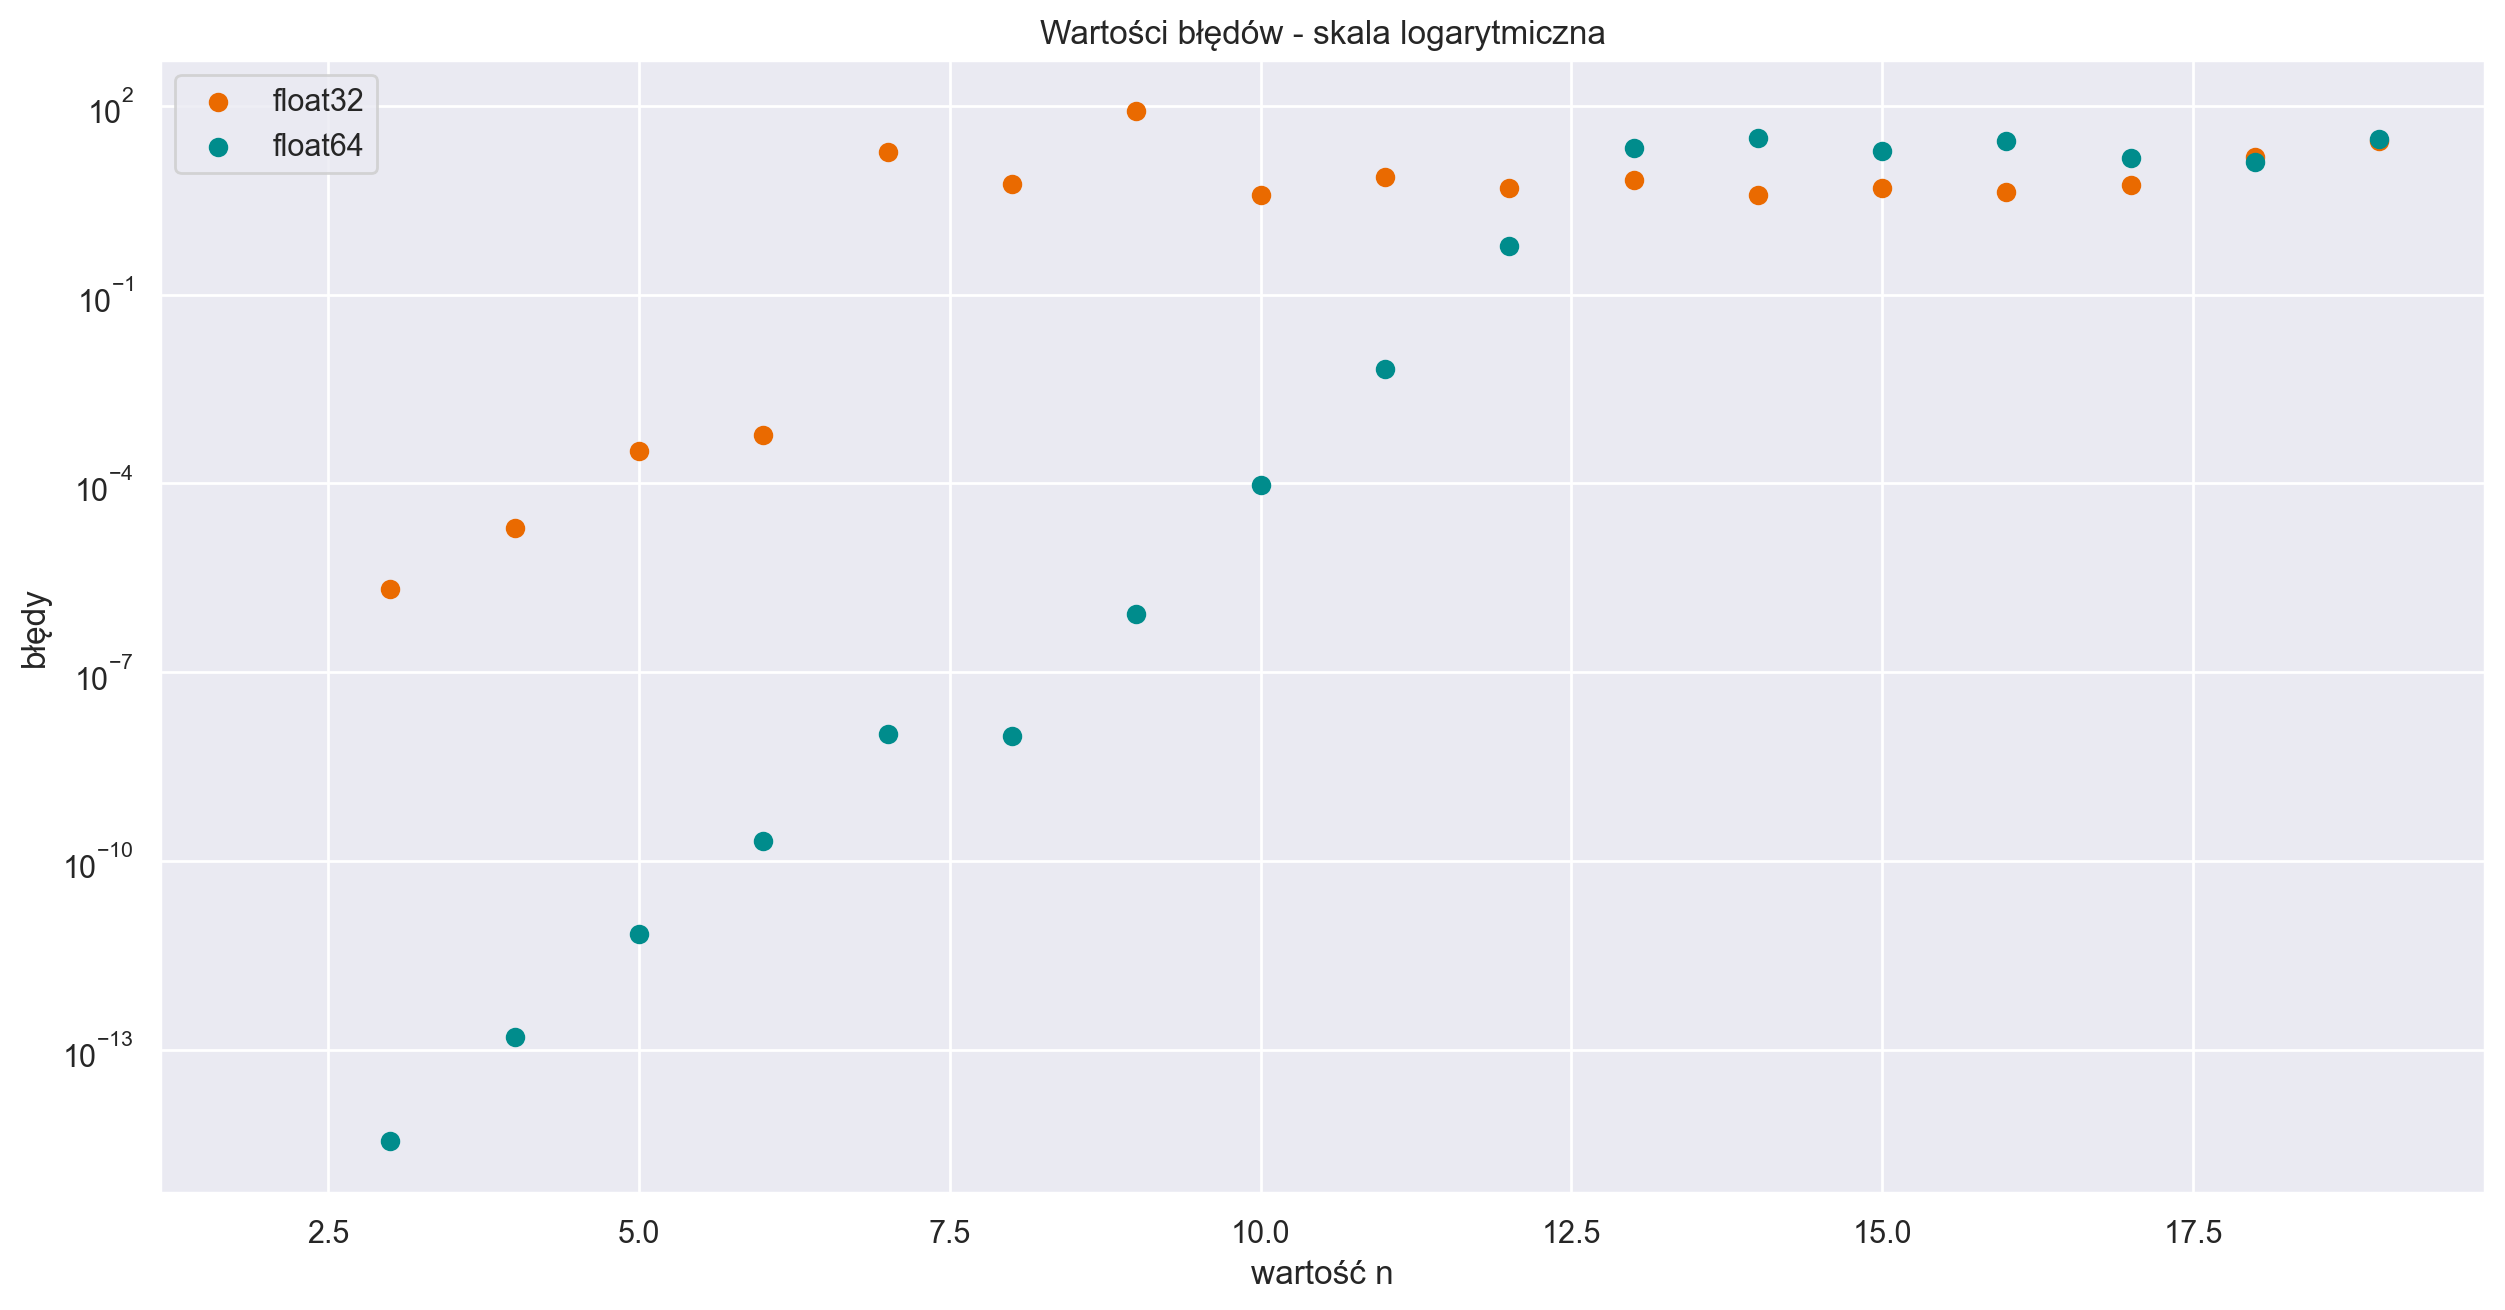

In [19]:
scatter(results, 'errors', 'Wartości błędów - skala logarytmiczna', 'błędy', 'log', range(2, 20))

#### Czasy obliczeń

##### Skala liniowa

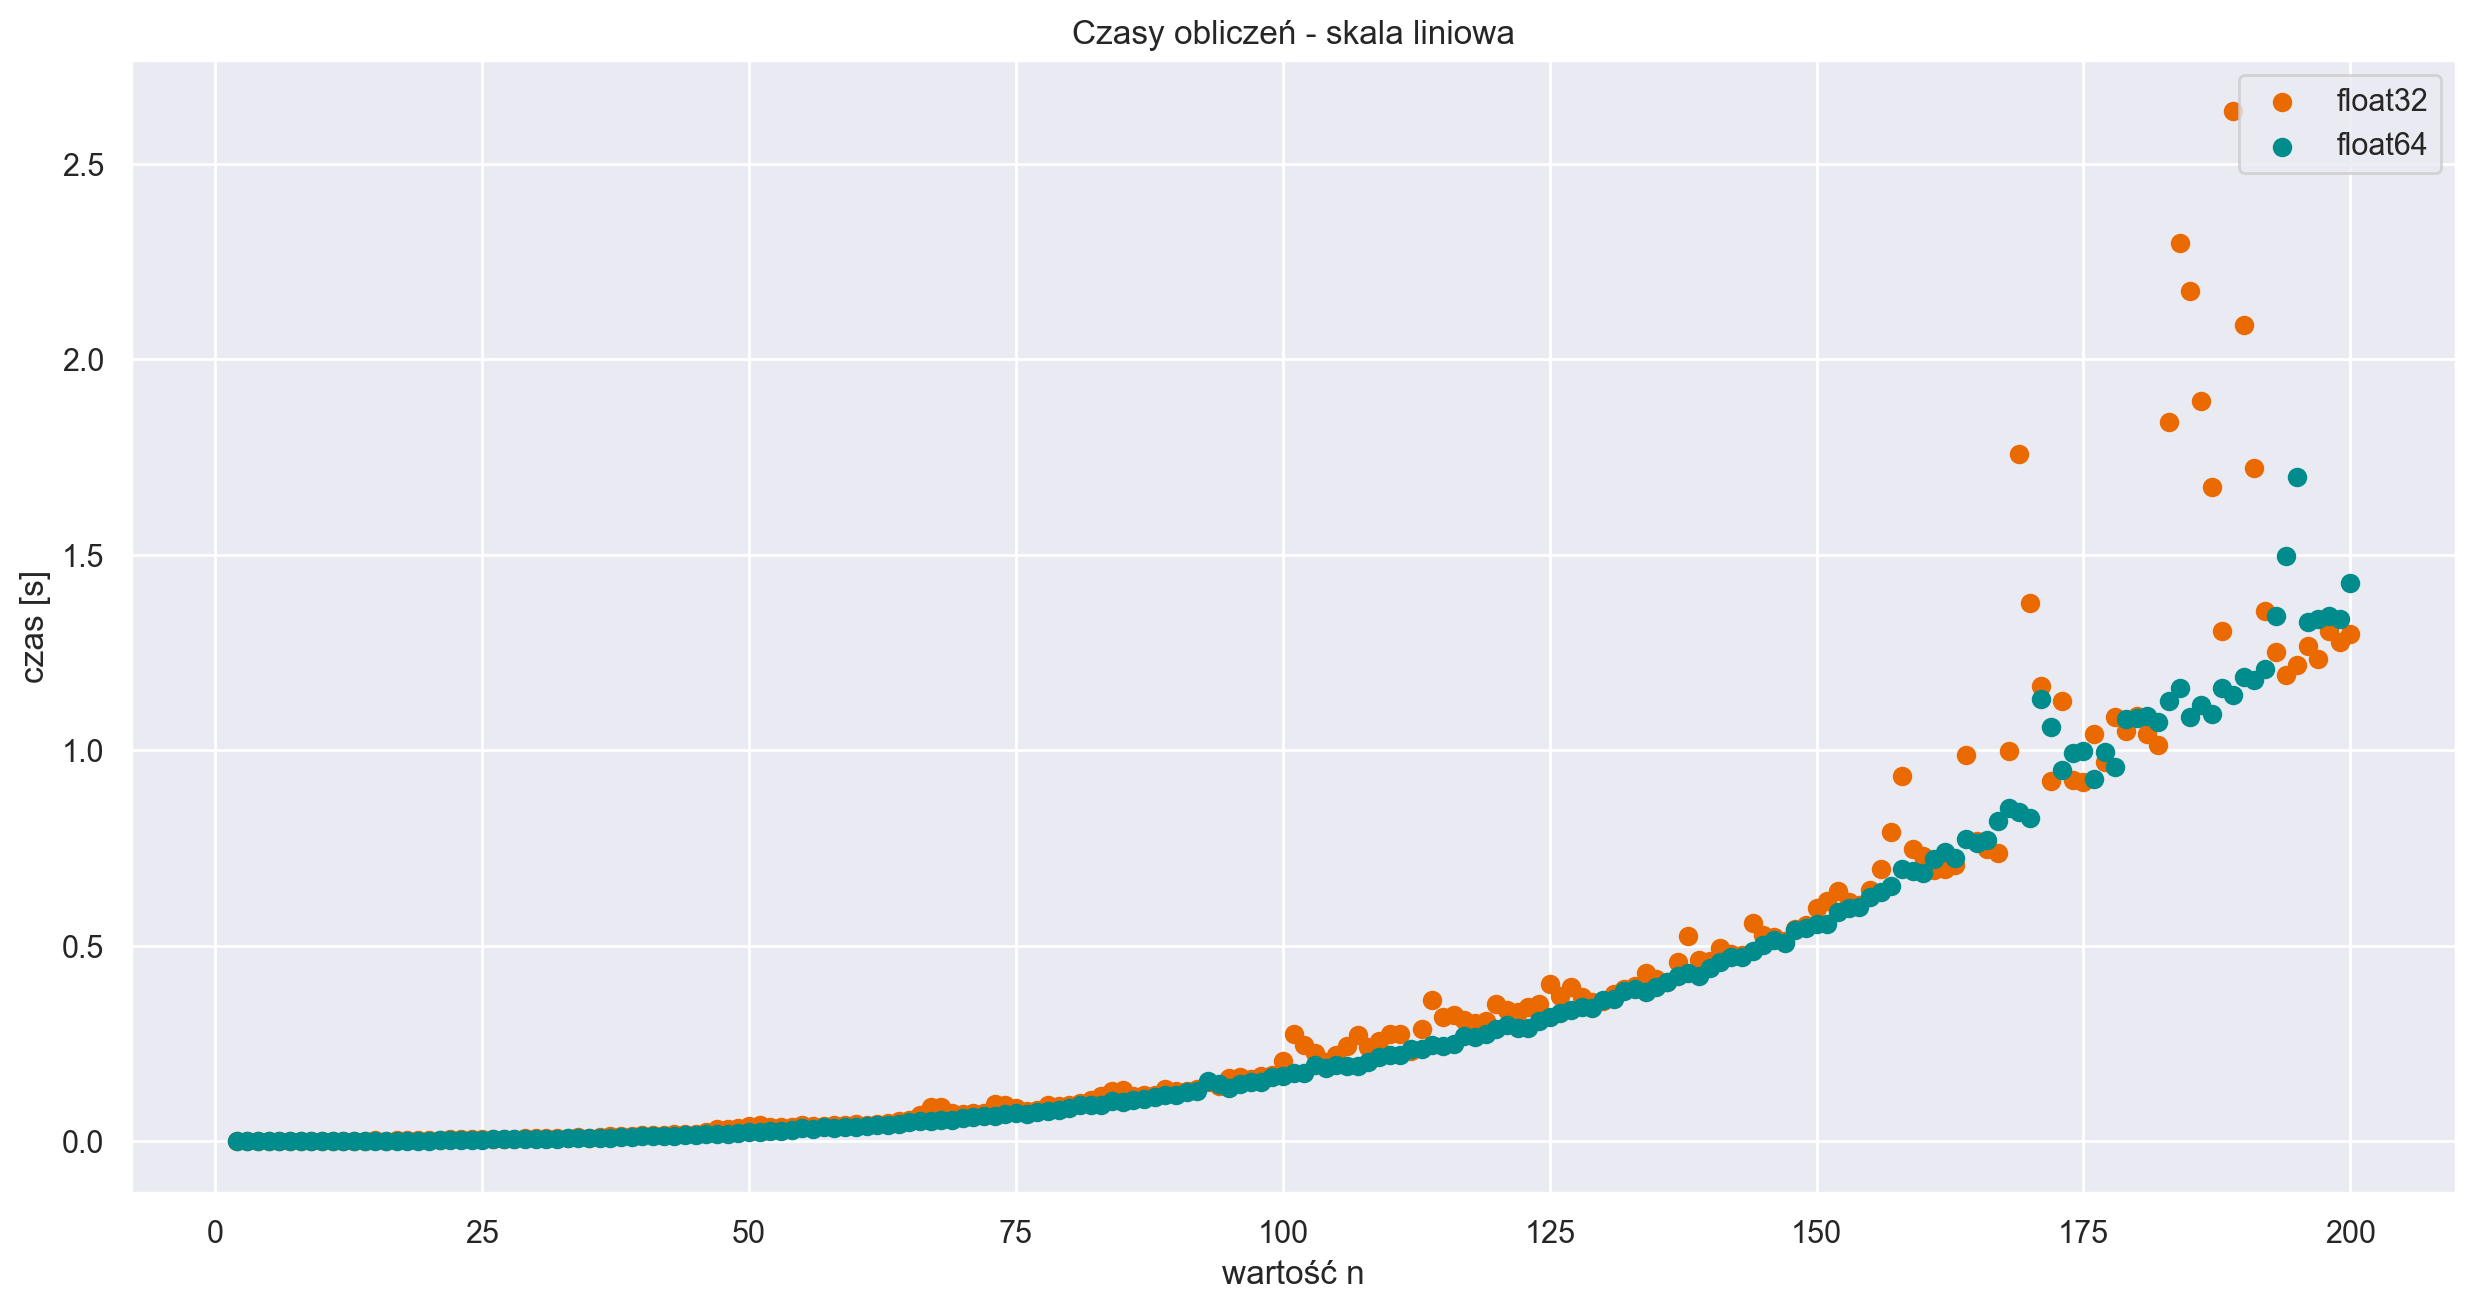

In [20]:
scatter(results, 'times', 'Czasy obliczeń - skala liniowa', 'czas [s]')

##### Skala logarytmiczna

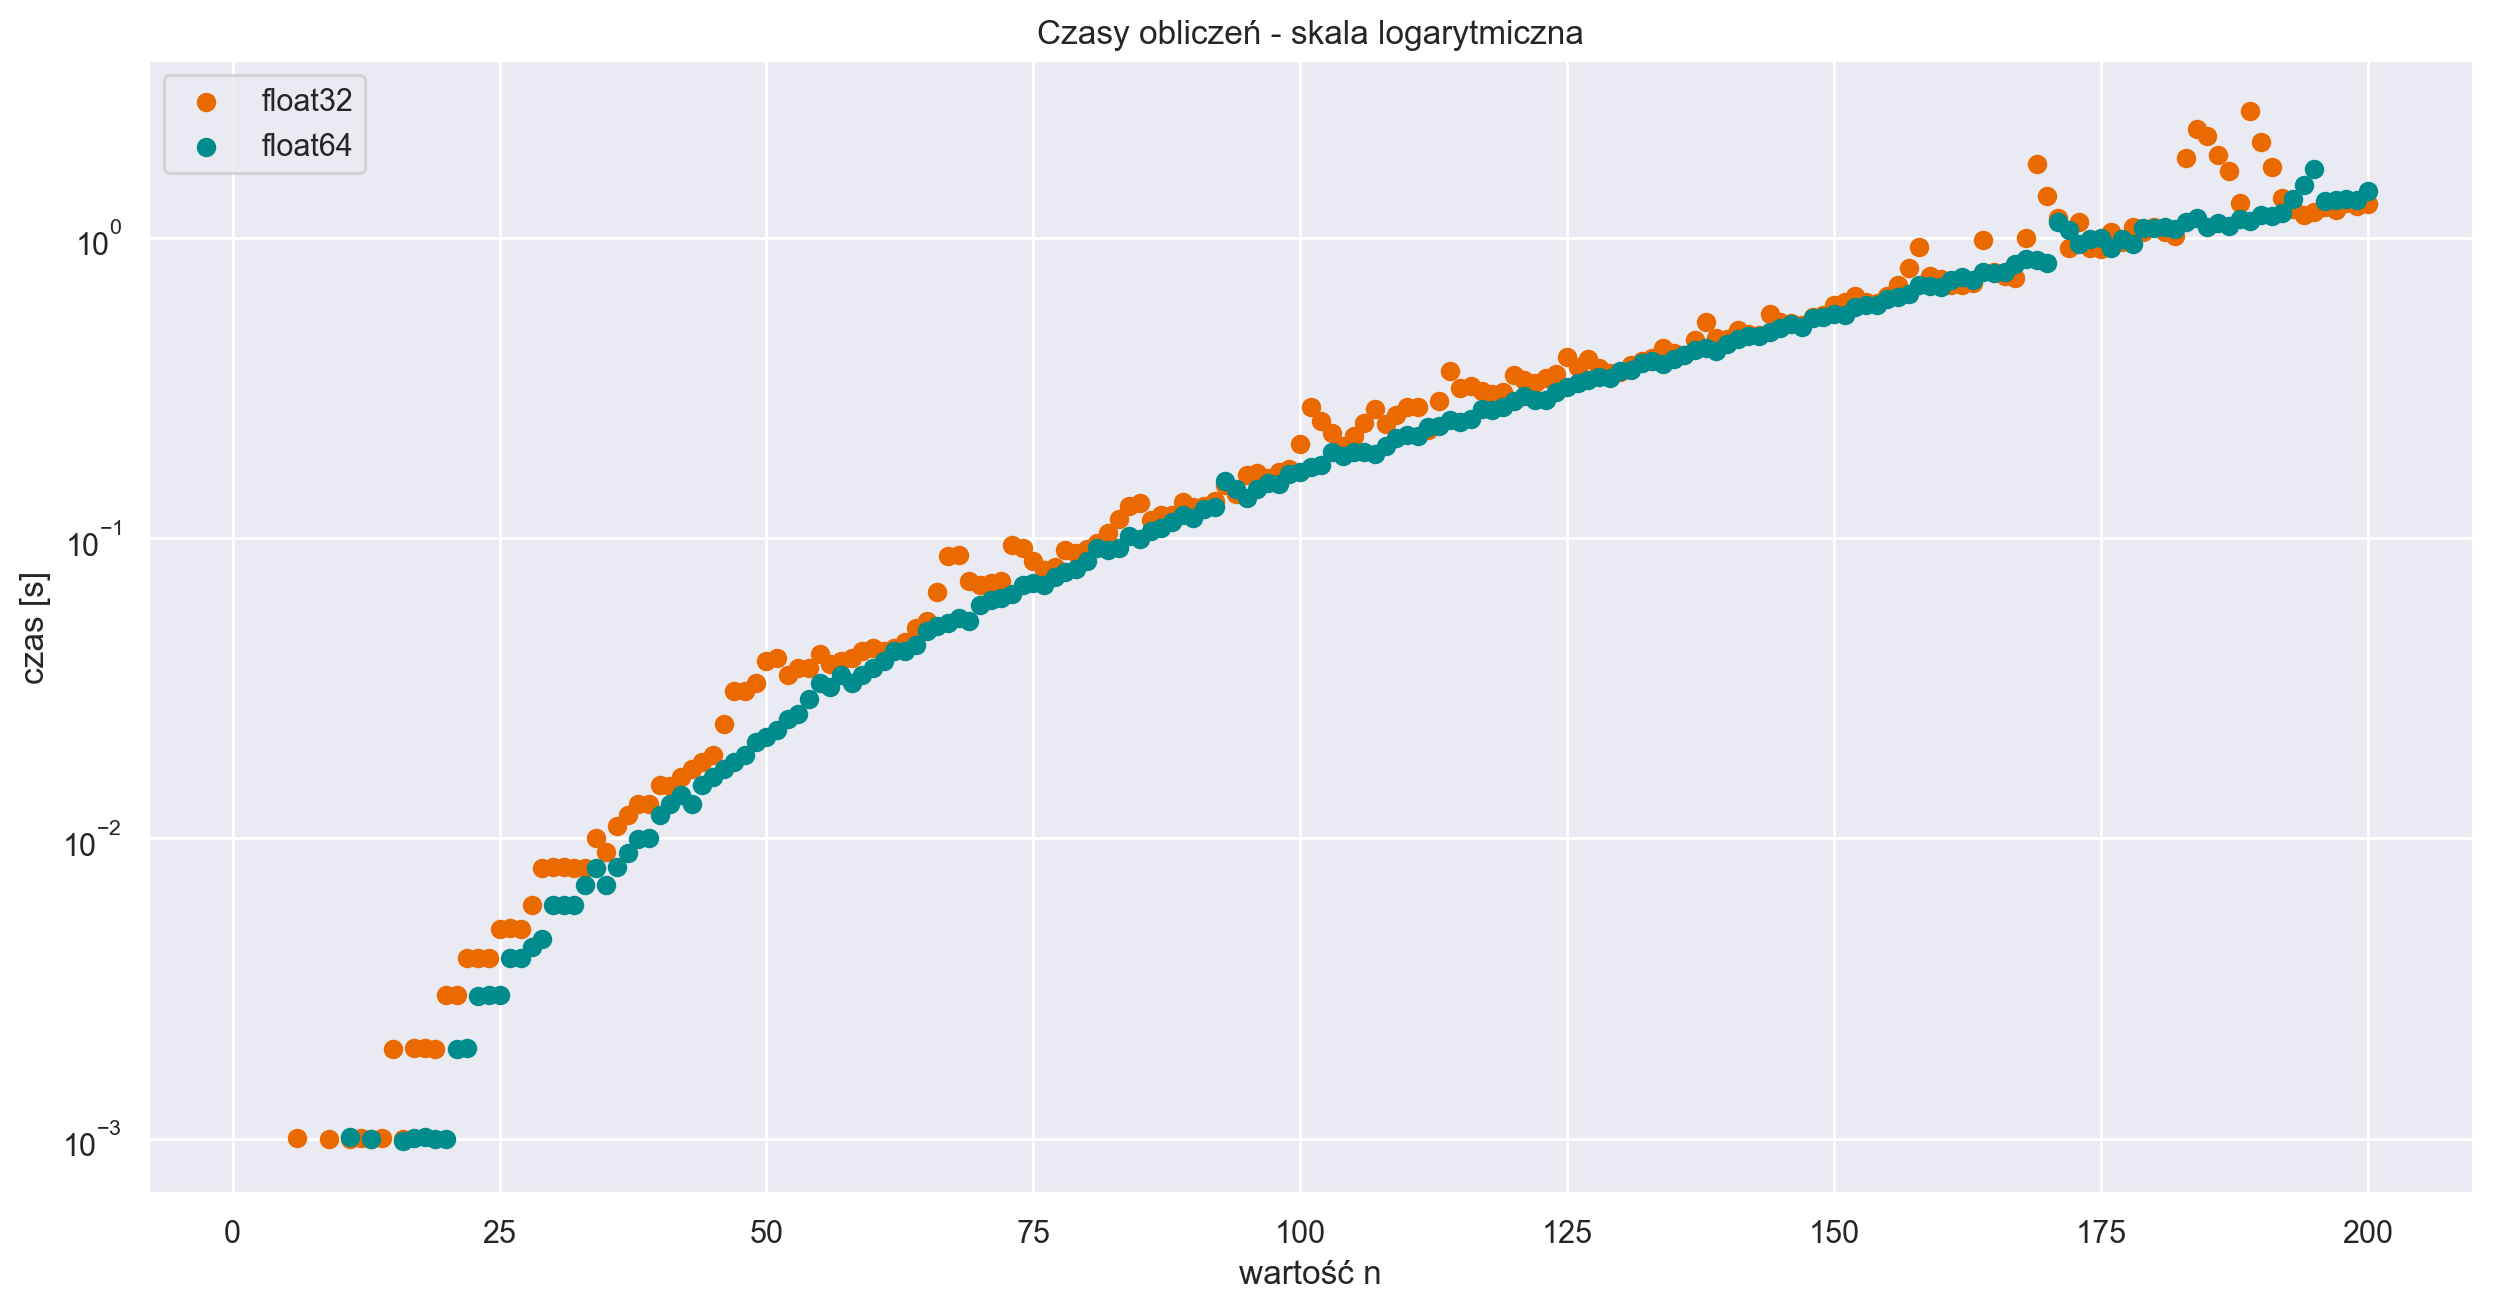

In [21]:
scatter(results, 'times', 'Czasy obliczeń - skala logarytmiczna', 'czas [s]', 'log')

### Wybrane wartości - zestawienie

##### Pomocnicza funkcja

In [32]:
def create_summary_df(results, ns):
    err32 = []
    err64 = []
    times32 = []
    times64 = []

    err32_values = list(results['float32']['errors'].values())
    err64_values = list(results['float64']['errors'].values())
    times32_values = list(results['float32']['times'].values())
    times64_values = list(results['float64']['times'].values())

    min_n = min(ns)
    for n in ns_part:
        err32.append(err32_values[n - min_n])
        err64.append(err64_values[n - min_n])
        times32.append(times32_values[n - min_n])
        times64.append(times64_values[n - min_n])

    df = pd.DataFrame(
        list(zip(ns_part, err32, err64, times32, times64)), 
         index=ns_part, 
         columns=('n', 'błąd float32', 'błąd float64', 'czas float32 [s]', 'czas float64 [s]')
    )
    
    return df

#### Zestawienie

In [42]:
min_n = 2
interval = 10

In [43]:
limit = 50

ns_part = list(ns)
ns_part = ns_part[:limit+1-min_n]
df1 = create_summary_df(results, ns_part)
df1

,n,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
2,2,0.000000e+00,0.000000e+00,0.000000,0.000000
3,3,1.192093e-07,2.220446e-16,0.000000,0.000000
4,4,1.192093e-07,4.440892e-16,0.000000,0.000000
5,5,1.192093e-07,6.661338e-16,0.000000,0.000000
6,6,2.384186e-07,4.440892e-16,0.000000,0.000000
7,7,2.384186e-07,9.992007e-16,0.000000,0.000000
8,8,9.536743e-07,2.220446e-15,0.000000,0.000000
9,9,9.536743e-07,2.442491e-15,0.000000,0.000000
10,10,9.536743e-07,2.220446e-15,0.001003,0.000000
11,11,1.311302e-06,3.774758e-15,0.000000,0.000000


In [45]:
ns_part = list(ns)
ns_part = [ns_part[0], *ns_part[interval-min_n::interval]]
df2 = create_summary_df(results, ns_part)
df2

,n,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
2,2,0.000000e+00,0.000000e+00,0.000000,0.000000
10,10,9.536743e-07,2.220446e-15,0.001003,0.000000
20,20,8.463860e-06,3.019807e-14,0.003000,0.002009
30,30,2.837181e-05,3.930190e-14,0.006000,0.005019
40,40,4.398823e-05,8.260059e-14,0.014002,0.011982
50,50,4.982948e-05,1.350031e-13,0.031020,0.024992
60,60,1.117587e-04,2.561285e-13,0.043999,0.040001
70,70,1.709461e-04,5.051515e-13,0.073005,0.056000
80,80,1.376867e-04,3.531619e-13,0.086994,0.091982
90,90,5.030632e-04,6.790124e-13,0.138999,0.116981


# Zadanie 2

## Opis problemu
### (analogiczny do tego z zadania 1)

Elementy macierzy $A$ dane są wzorem:

$
\begin{cases} 
    a_{1, j} = \frac{2i}{j} & dla j \ge i \\ 
    a_{i, j} = a_{j, i} & dla j < i \\
\end{cases}
$

gdzie $i, j \in \{1, 2, ..., n\}$

## Tworzenie macierzy

### Implementacja funkcji, zgodnie z którą wypełnione są wartości macierzy

In [23]:
def fn(i: int, j: int) -> float:
    if j >= i:
        return 2 * i / j
    return fn(j, i)

###### Test

In [24]:
n = 4
A = create_matrix(fn, n, n)
A

array([[2.        , 1.        , 0.66666667, 0.5       ],
       [1.        , 2.        , 1.33333333, 1.        ],
       [0.66666667, 1.33333333, 2.        , 1.5       ],
       [0.5       , 1.        , 1.5       , 2.        ]])

## Rozwiązanie zadania

Resetujemy wyniki poprzednich obliczeń

In [25]:
times.clear()

Możemy ponownie skorzystać z kodu, który był w poprzednim zadaniu. Ponieważ nadpisaliśmy definicję funkcji `fn` generującej macierz $A$, nie musimy zmieniać nic w poprzedniej implementacji, ponieważ teraz do wygenerowania macierzy $A$ zostanie użyta nowa funkcja.

In [26]:
ns = range(2, 201)
precs = {
    'float32': np.float32, 
    'float64': np.float64
}
results = calculate(ns, precs)
print_duration(times['total'])

========== float32 ==========
Obliczono 25 układów równań
Obliczono 50 układów równań
Obliczono 75 układów równań
Obliczono 100 układów równań
Obliczono 125 układów równań
Obliczono 150 układów równań
Obliczono 175 układów równań

========== float64 ==========
Obliczono 25 układów równań
Obliczono 50 układów równań
Obliczono 75 układów równań
Obliczono 100 układów równań
Obliczono 125 układów równań
Obliczono 150 układów równań
Obliczono 175 układów równań

Total execution time: 00:02:31.753



### Wykresy

Możemy ponownie użyć tej samej funkcji.

#### Błędy obliczeń

##### Skala liniowa

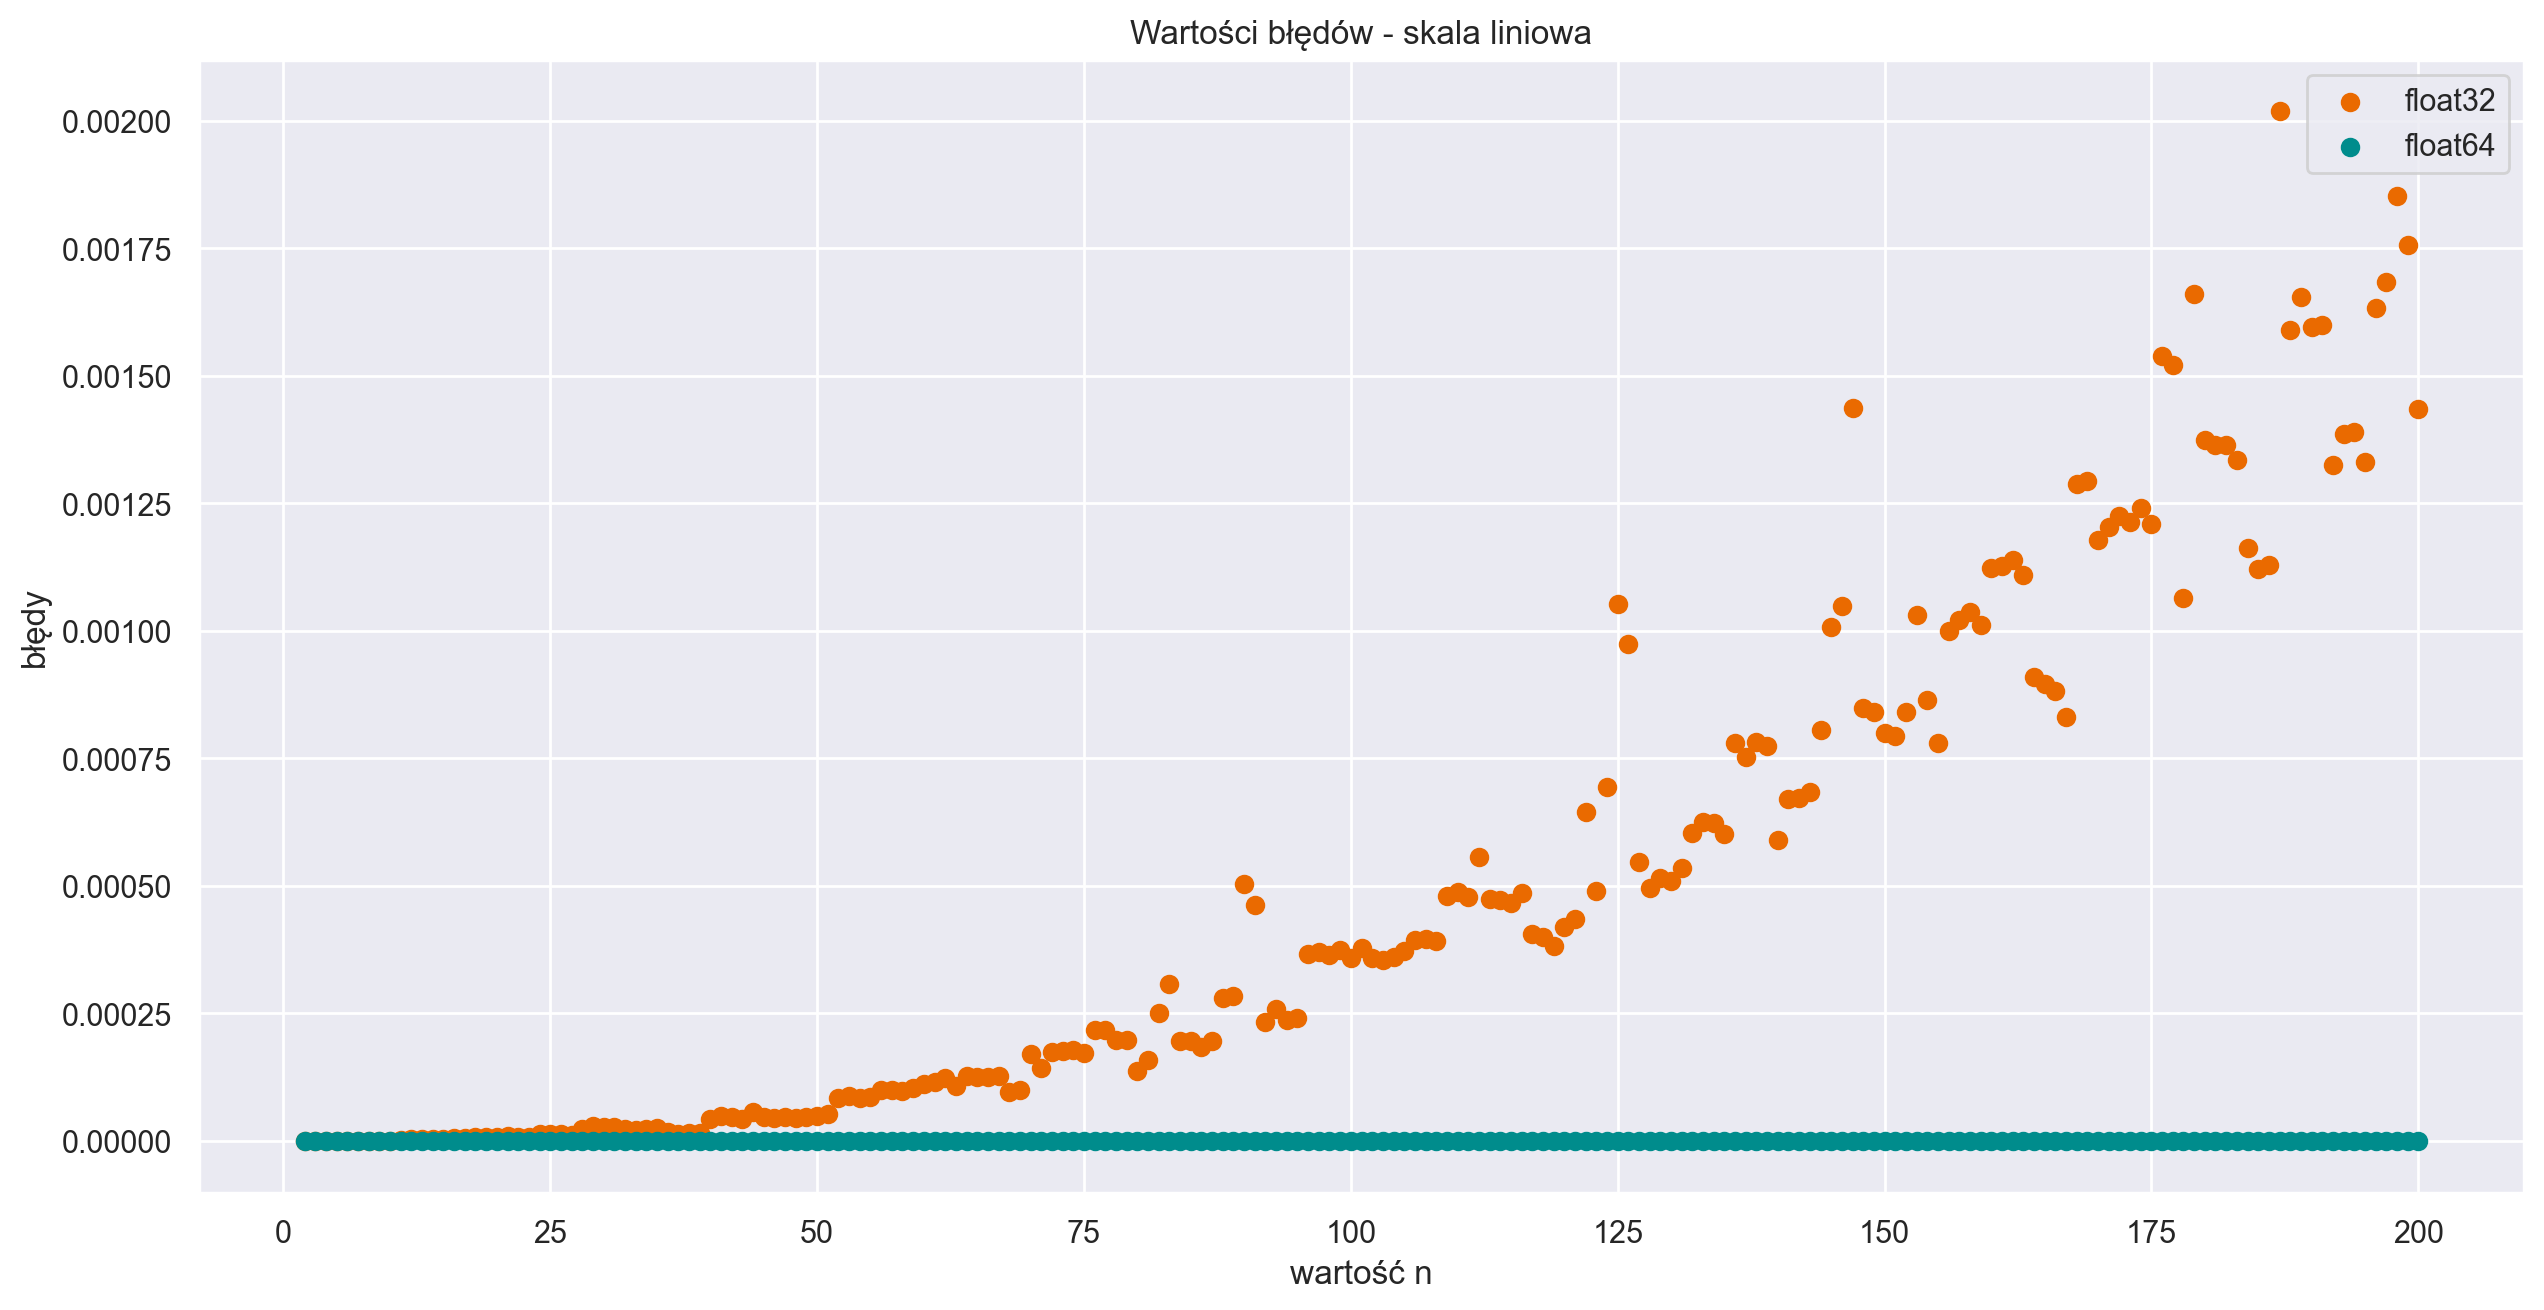

In [27]:
scatter(results, 'errors', 'Wartości błędów - skala liniowa', 'błędy')

##### Skala logarytmiczna

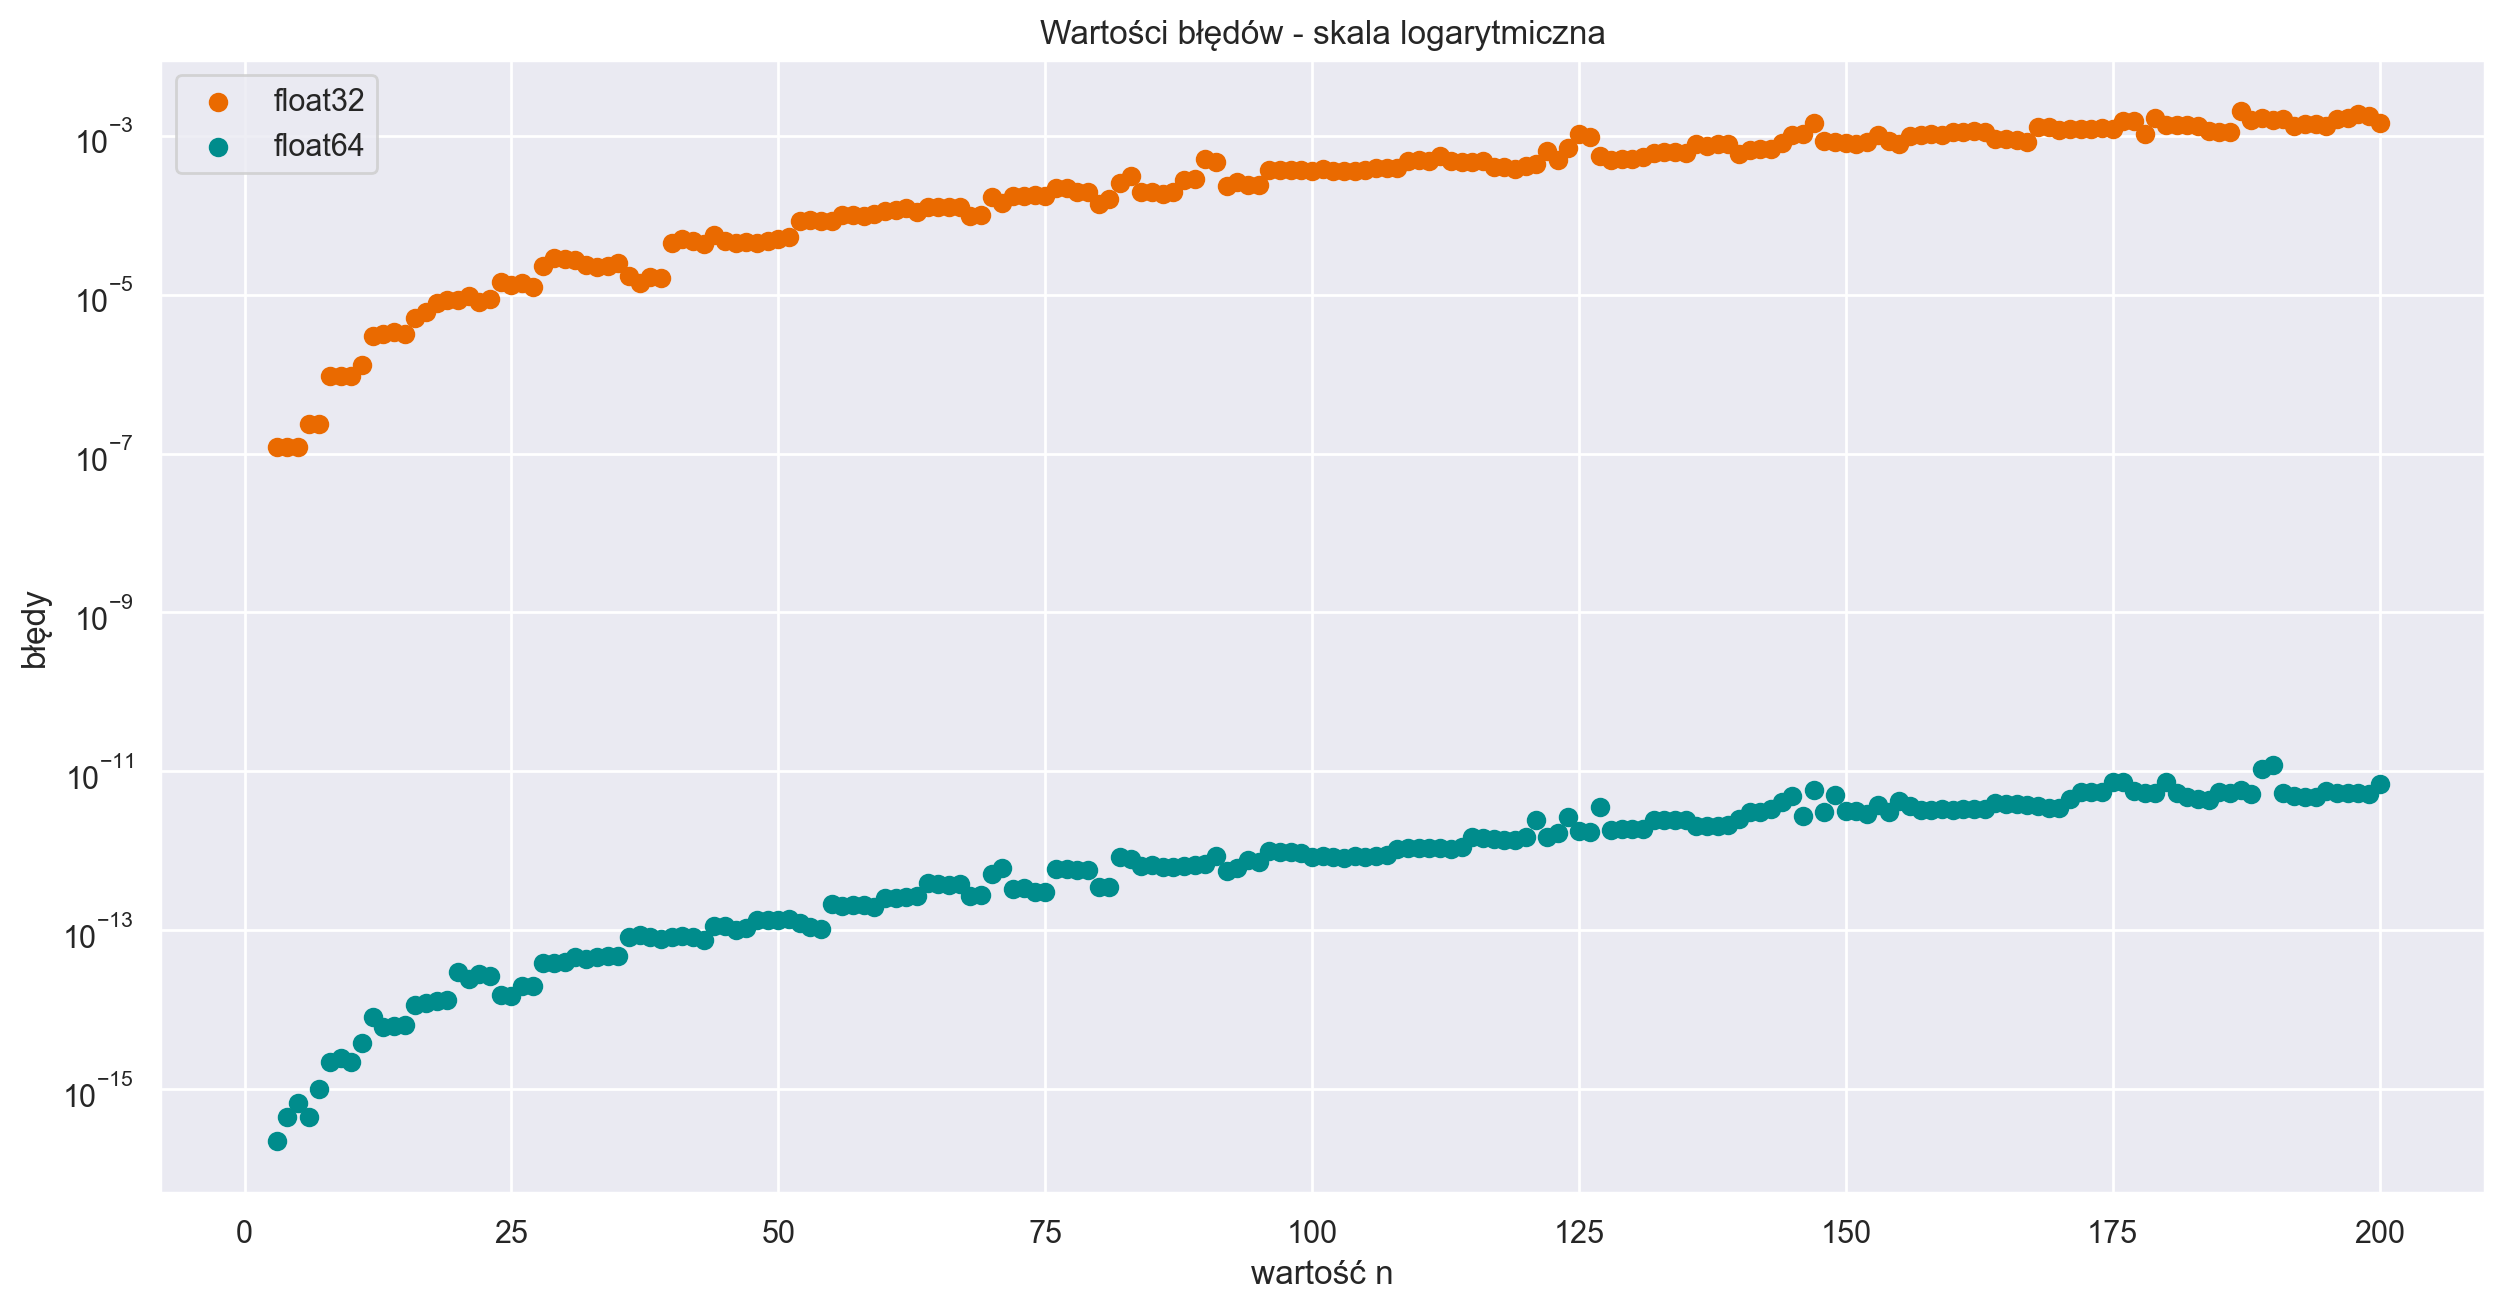

In [28]:
scatter(results, 'errors', 'Wartości błędów - skala logarytmiczna', 'błędy', 'log')

#### Czasy obliczeń

##### Skala liniowa

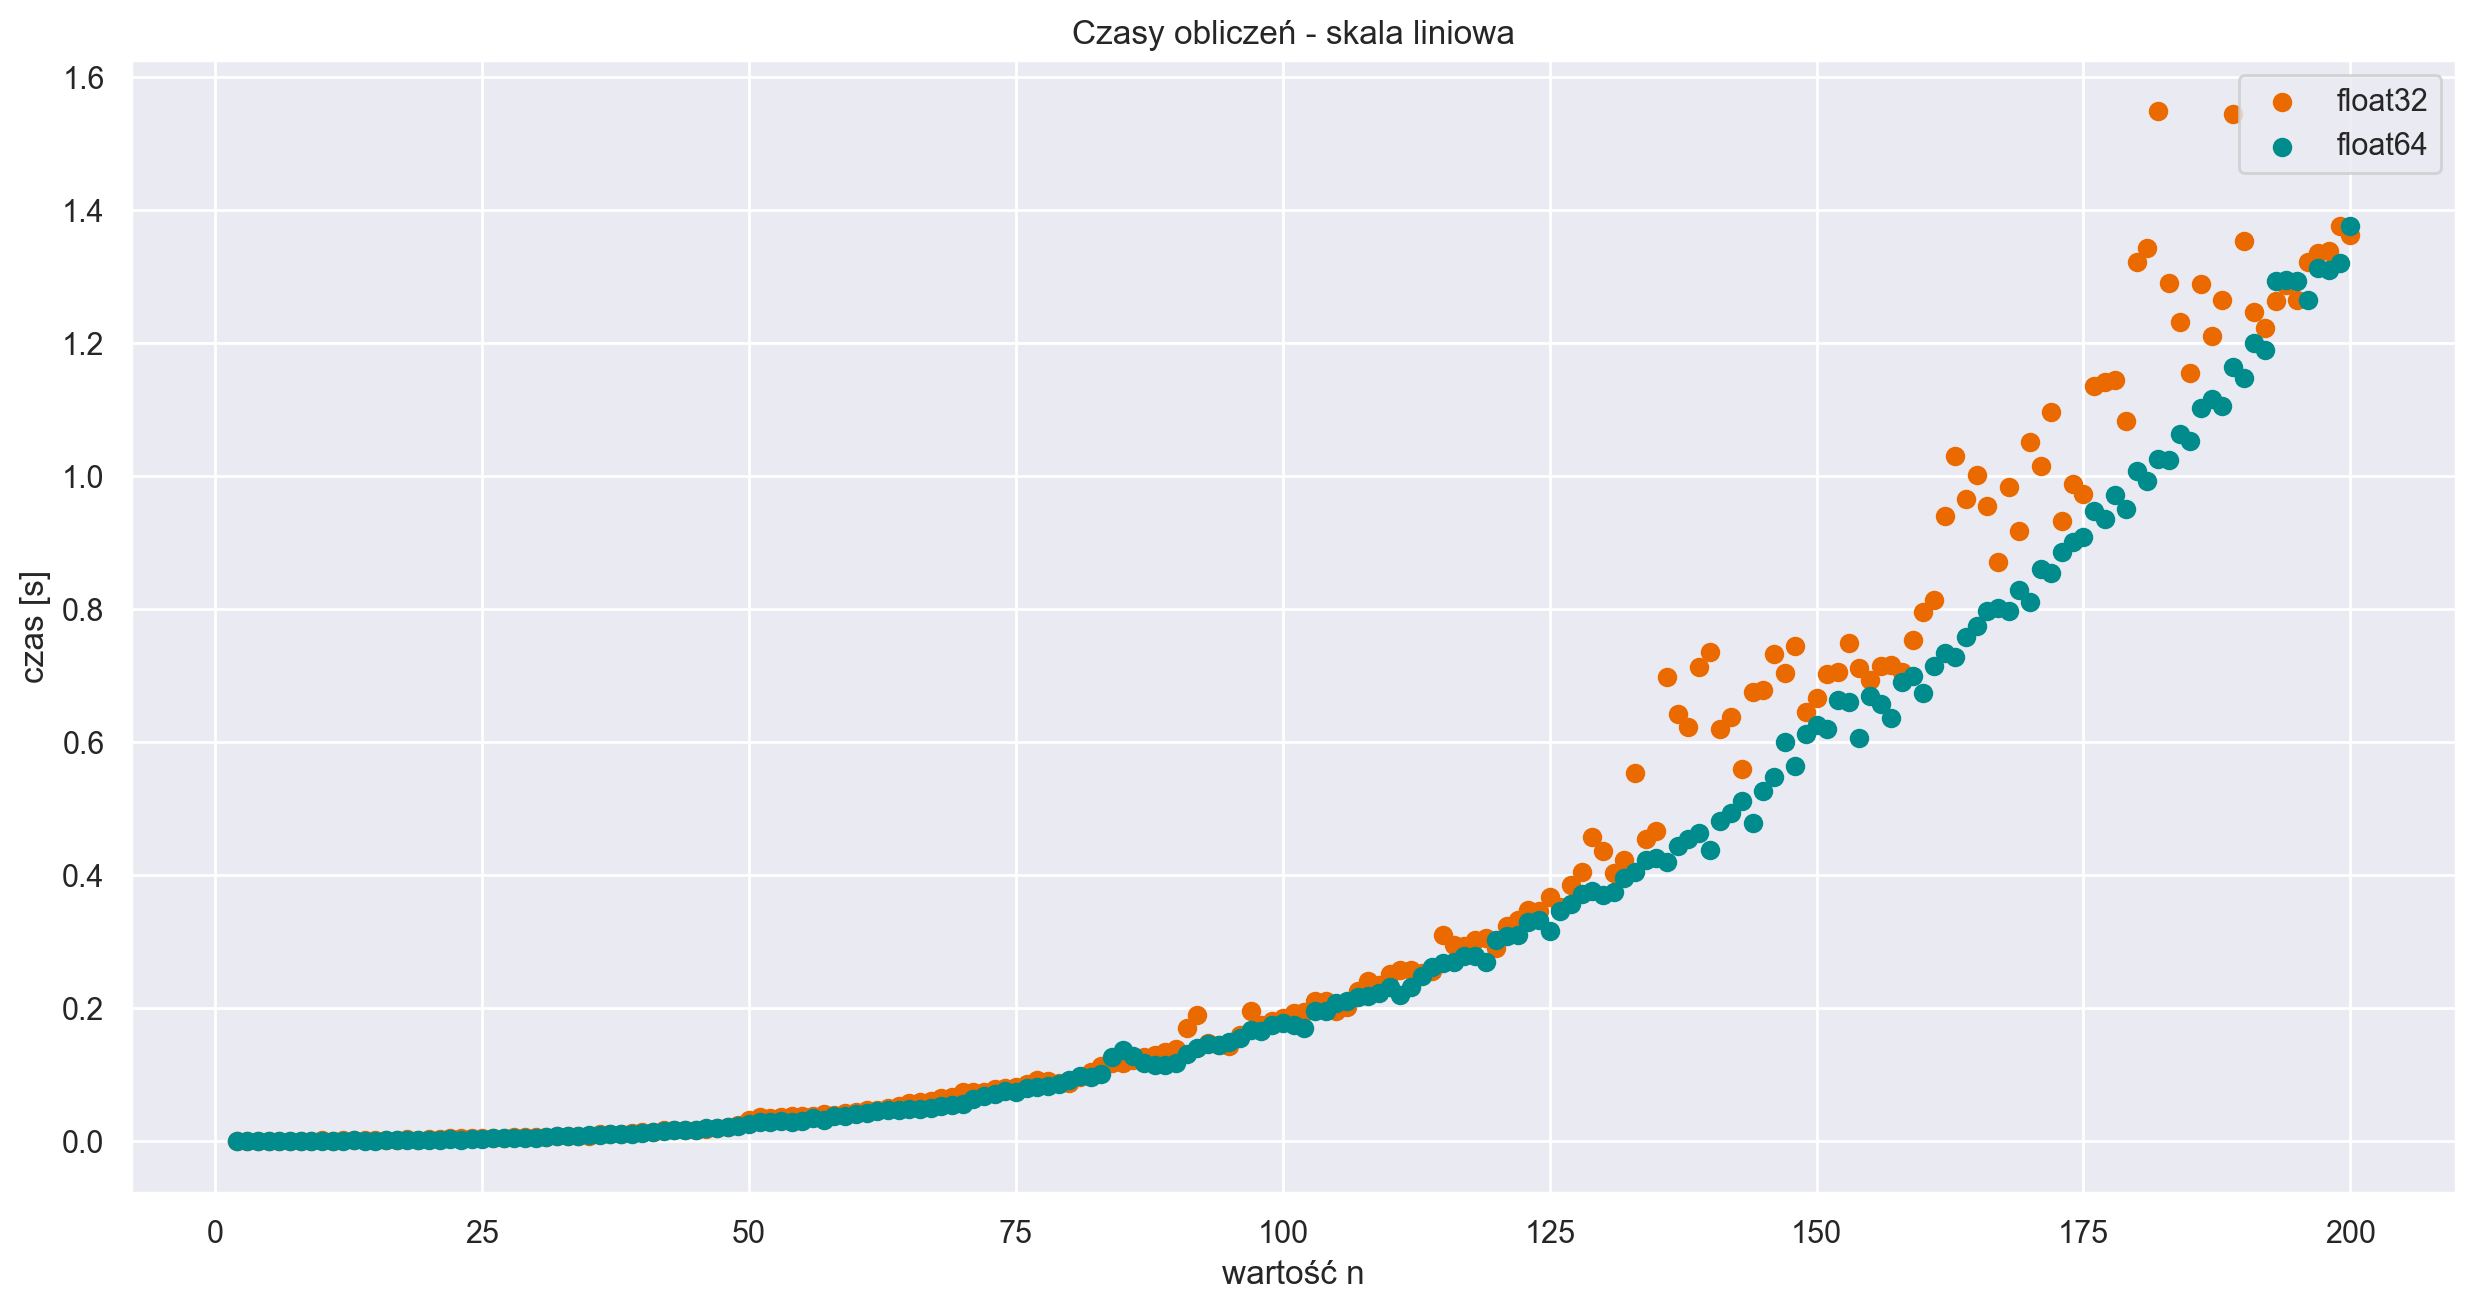

In [29]:
scatter(results, 'times', 'Czasy obliczeń - skala liniowa', 'czas [s]')

##### Skala logarytmiczna

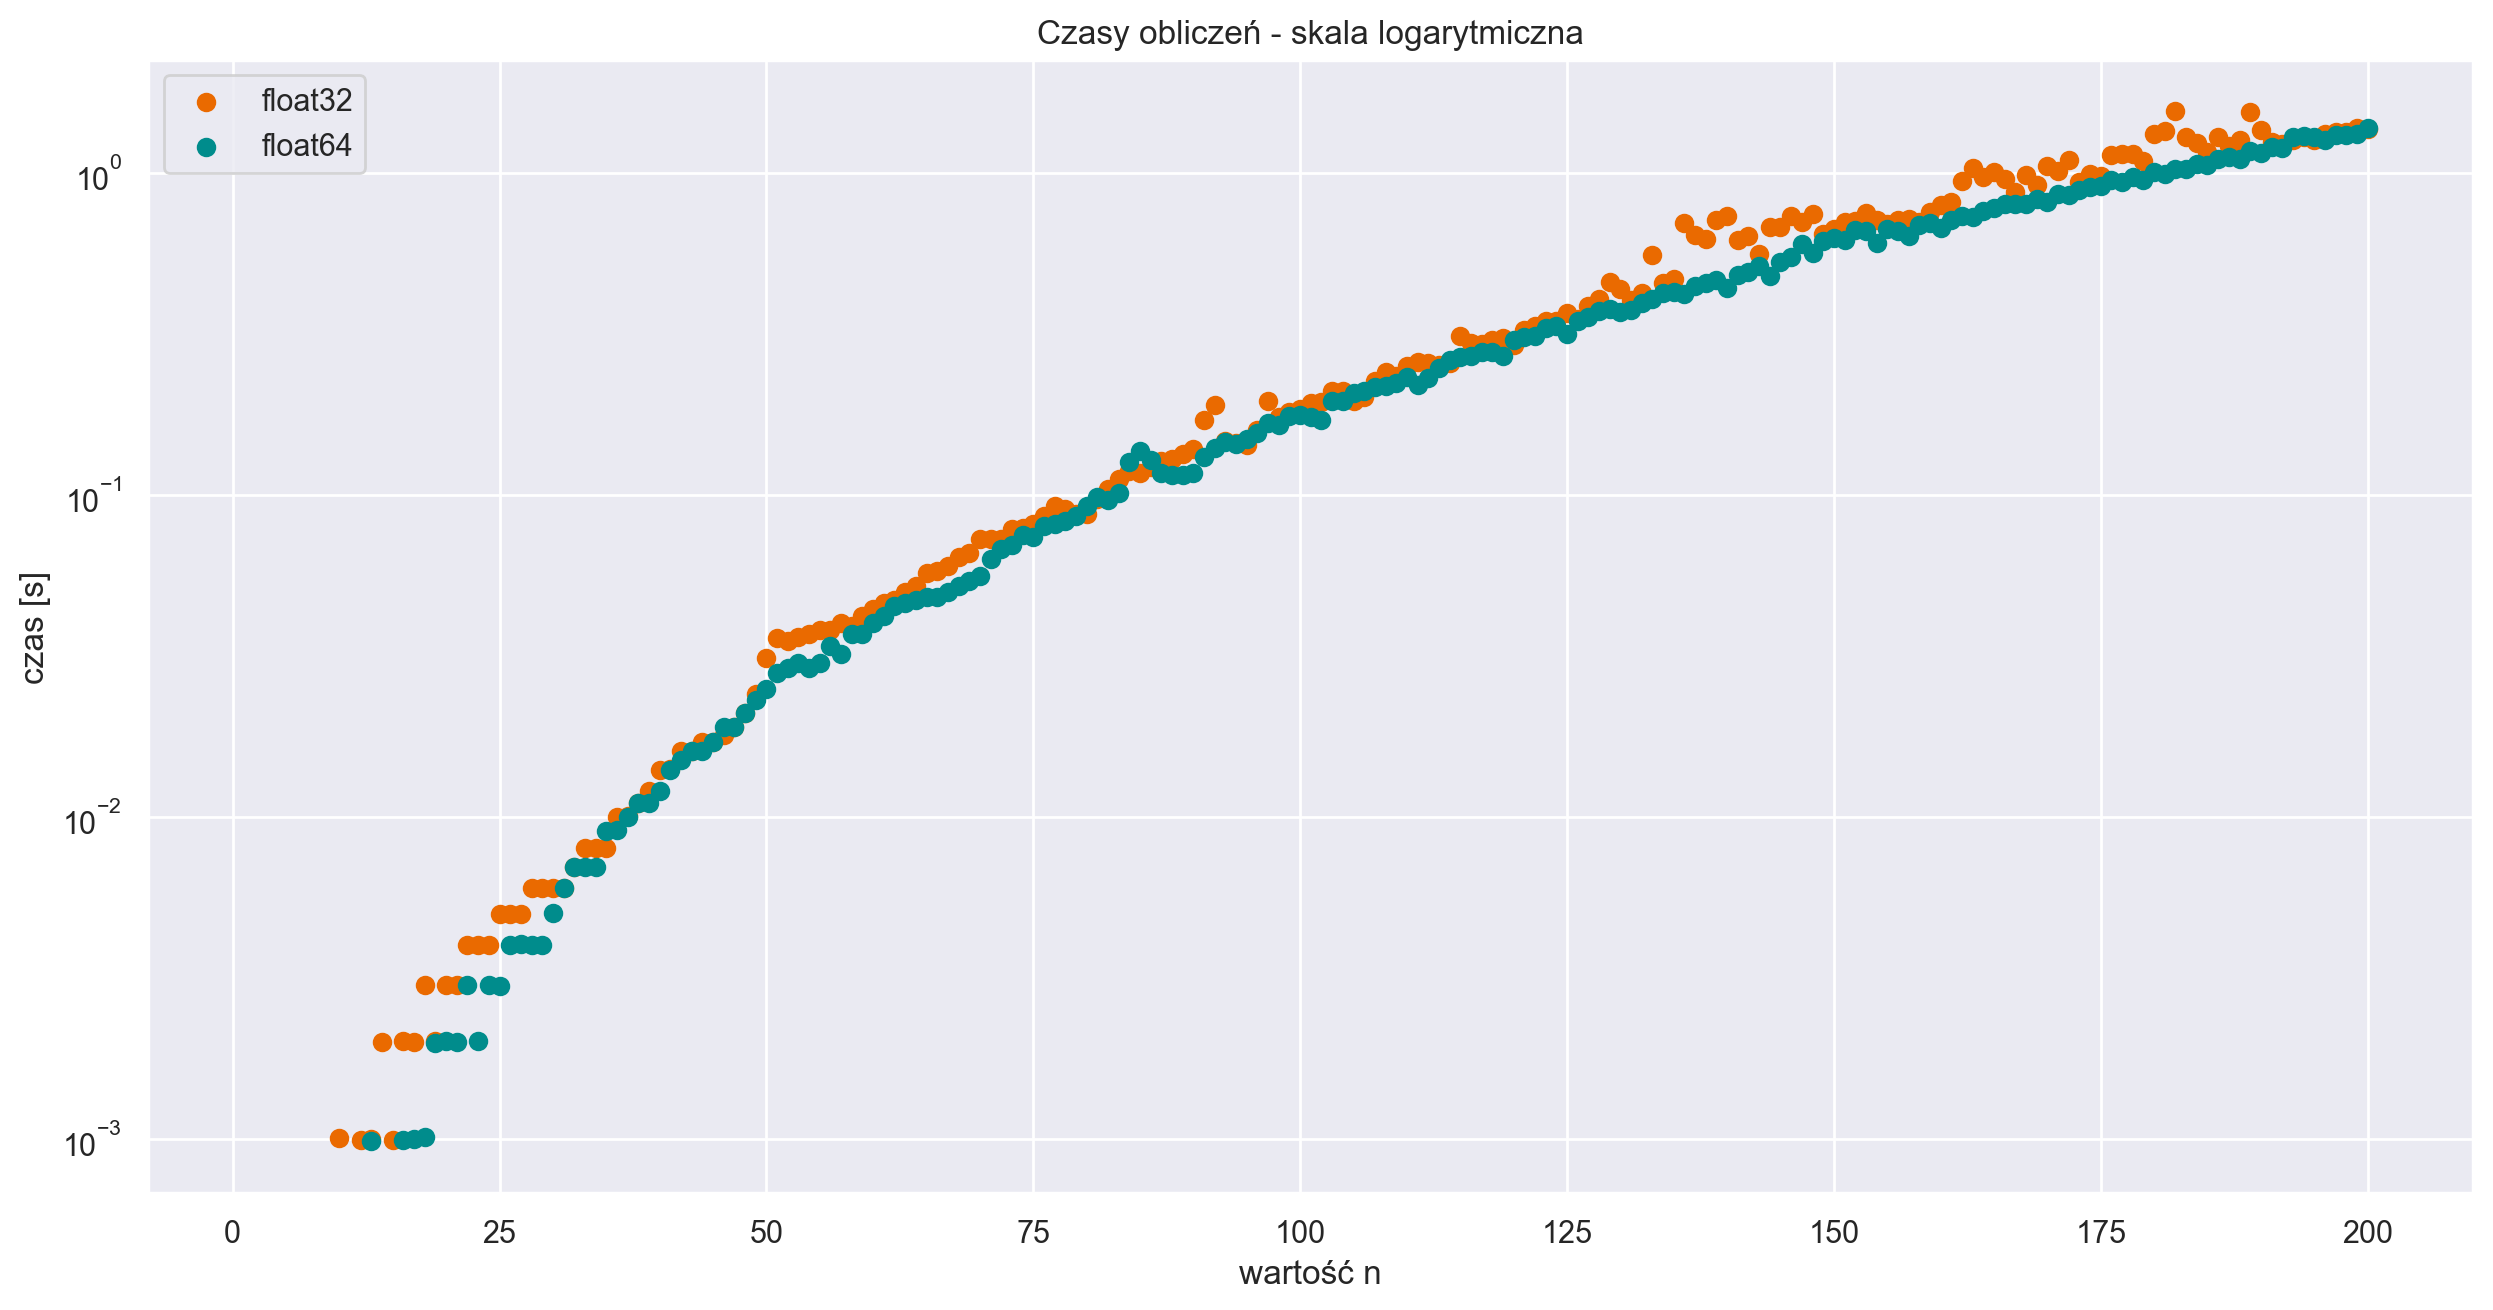

In [30]:
scatter(results, 'times', 'Czasy obliczeń - skala logarytmiczna', 'czas [s]', 'log')

### Wybrane wartości - zestawienie

Ponownie wykorzystamy zaimplementowaną wcześniej funkcję pomocniczą, tworzącą zestawienie w postaci tabeli.

#### Zestawienie 

In [47]:
min_n = 2
interval = 10

In [48]:
limit = 50

ns_part = list(ns)
ns_part = ns_part[:limit+1-min_n]
df1 = create_summary_df(results, ns_part)
df1

,n,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
2,2,0.000000e+00,0.000000e+00,0.000000,0.000000
3,3,1.192093e-07,2.220446e-16,0.000000,0.000000
4,4,1.192093e-07,4.440892e-16,0.000000,0.000000
5,5,1.192093e-07,6.661338e-16,0.000000,0.000000
6,6,2.384186e-07,4.440892e-16,0.000000,0.000000
7,7,2.384186e-07,9.992007e-16,0.000000,0.000000
8,8,9.536743e-07,2.220446e-15,0.000000,0.000000
9,9,9.536743e-07,2.442491e-15,0.000000,0.000000
10,10,9.536743e-07,2.220446e-15,0.001003,0.000000
11,11,1.311302e-06,3.774758e-15,0.000000,0.000000


In [49]:
ns_part = list(ns)
ns_part = [ns_part[0], *ns_part[interval-min_n::interval]]
df2 = create_summary_df(results, ns_part)
df2

,n,błąd float32,błąd float64,czas float32 [s],czas float64 [s]
2,2,0.000000e+00,0.000000e+00,0.000000,0.000000
10,10,9.536743e-07,2.220446e-15,0.001003,0.000000
20,20,8.463860e-06,3.019807e-14,0.003000,0.002009
30,30,2.837181e-05,3.930190e-14,0.006000,0.005019
40,40,4.398823e-05,8.260059e-14,0.014002,0.011982
50,50,4.982948e-05,1.350031e-13,0.031020,0.024992
60,60,1.117587e-04,2.561285e-13,0.043999,0.040001
70,70,1.709461e-04,5.051515e-13,0.073005,0.056000
80,80,1.376867e-04,3.531619e-13,0.086994,0.091982
90,90,5.030632e-04,6.790124e-13,0.138999,0.116981


### Współczynniki uwarunkowania

#### Funkcja, obliczająca współczynnik uwarunkowania macierzy $A$

In [60]:
def norm(A):
    n = len(A)
    return max(sum(A[i, j] for j in range(n)) for i in range(n))

def conditioning_factor(A):
    A_inv = np.linalg.inv(A)
    return norm(A_inv) * norm(A)

### Porównanie uwarunkowania dla macierzy $A$ z zadania 1 i zadania 2

#### Pomocnicze funkcje, tworzące odpowiednie macierze

In [72]:
# Matrix from the 1st exercise
def create_A1(n):
    a = lambda i, j: 1 if i == 1 else 1 / (i + j - 1)
    return create_matrix(a, n, n)
    
# Matrix from the 2nd exercise
def create_A2(n):
    a = lambda i, j: 2 * i / j if j >= i else a(j, i)
    return create_matrix(a, n, n)

#### Zestawienie wartości współczynników uwarunkowania

In [73]:
min_n = 2
max_n = 200
ns = list(range(min_n, max_n + 1))

cond_fact1 = [conditioning_factor(create_A1(n)) for n in ns]
cond_fact2 = [conditioning_factor(create_A2(n)) for n in ns]

cond_df = pd.DataFrame(zip(cond_fact1, cond_fact2), columns=['Zadanie 1', 'Zadanie 2'], index=ns)
cond_df

,Zadanie 1,Zadanie 2
2,8.000000e+00,1.000000
3,2.160000e+02,1.444444
4,2.880000e+03,1.833333
5,2.800000e+04,2.233333
6,2.268000e+05,2.644444
...,...,...
196,5.036364e+16,79.455975
197,1.546065e+16,79.860296
198,3.712693e+16,80.264336
199,2.052901e+16,80.669121


####  Porównanie wartości współczynników uwarunkowania na wykresach

##### Pomocnicza funkcja

In [95]:
def conditioning_factors_plot(df, title, scale=None):
    fig, ax = plt.subplots(figsize=(15, 7.5))
    if scale: ax.set_yscale(scale)
    plt.scatter(x=df.index.tolist(), y=df['Zadanie 1'], c='#EA6A00', label='Zadanie 1')
    plt.scatter(x=df.index.tolist(), y=df['Zadanie 2'], c='#008C8C', label='Zadanie 2')
    plt.title(title)
    plt.xlabel('wartość n')
    plt.ylabel('współczynnik uwarunkowania')
    plt.legend()
    plt.show()

##### Wykresy

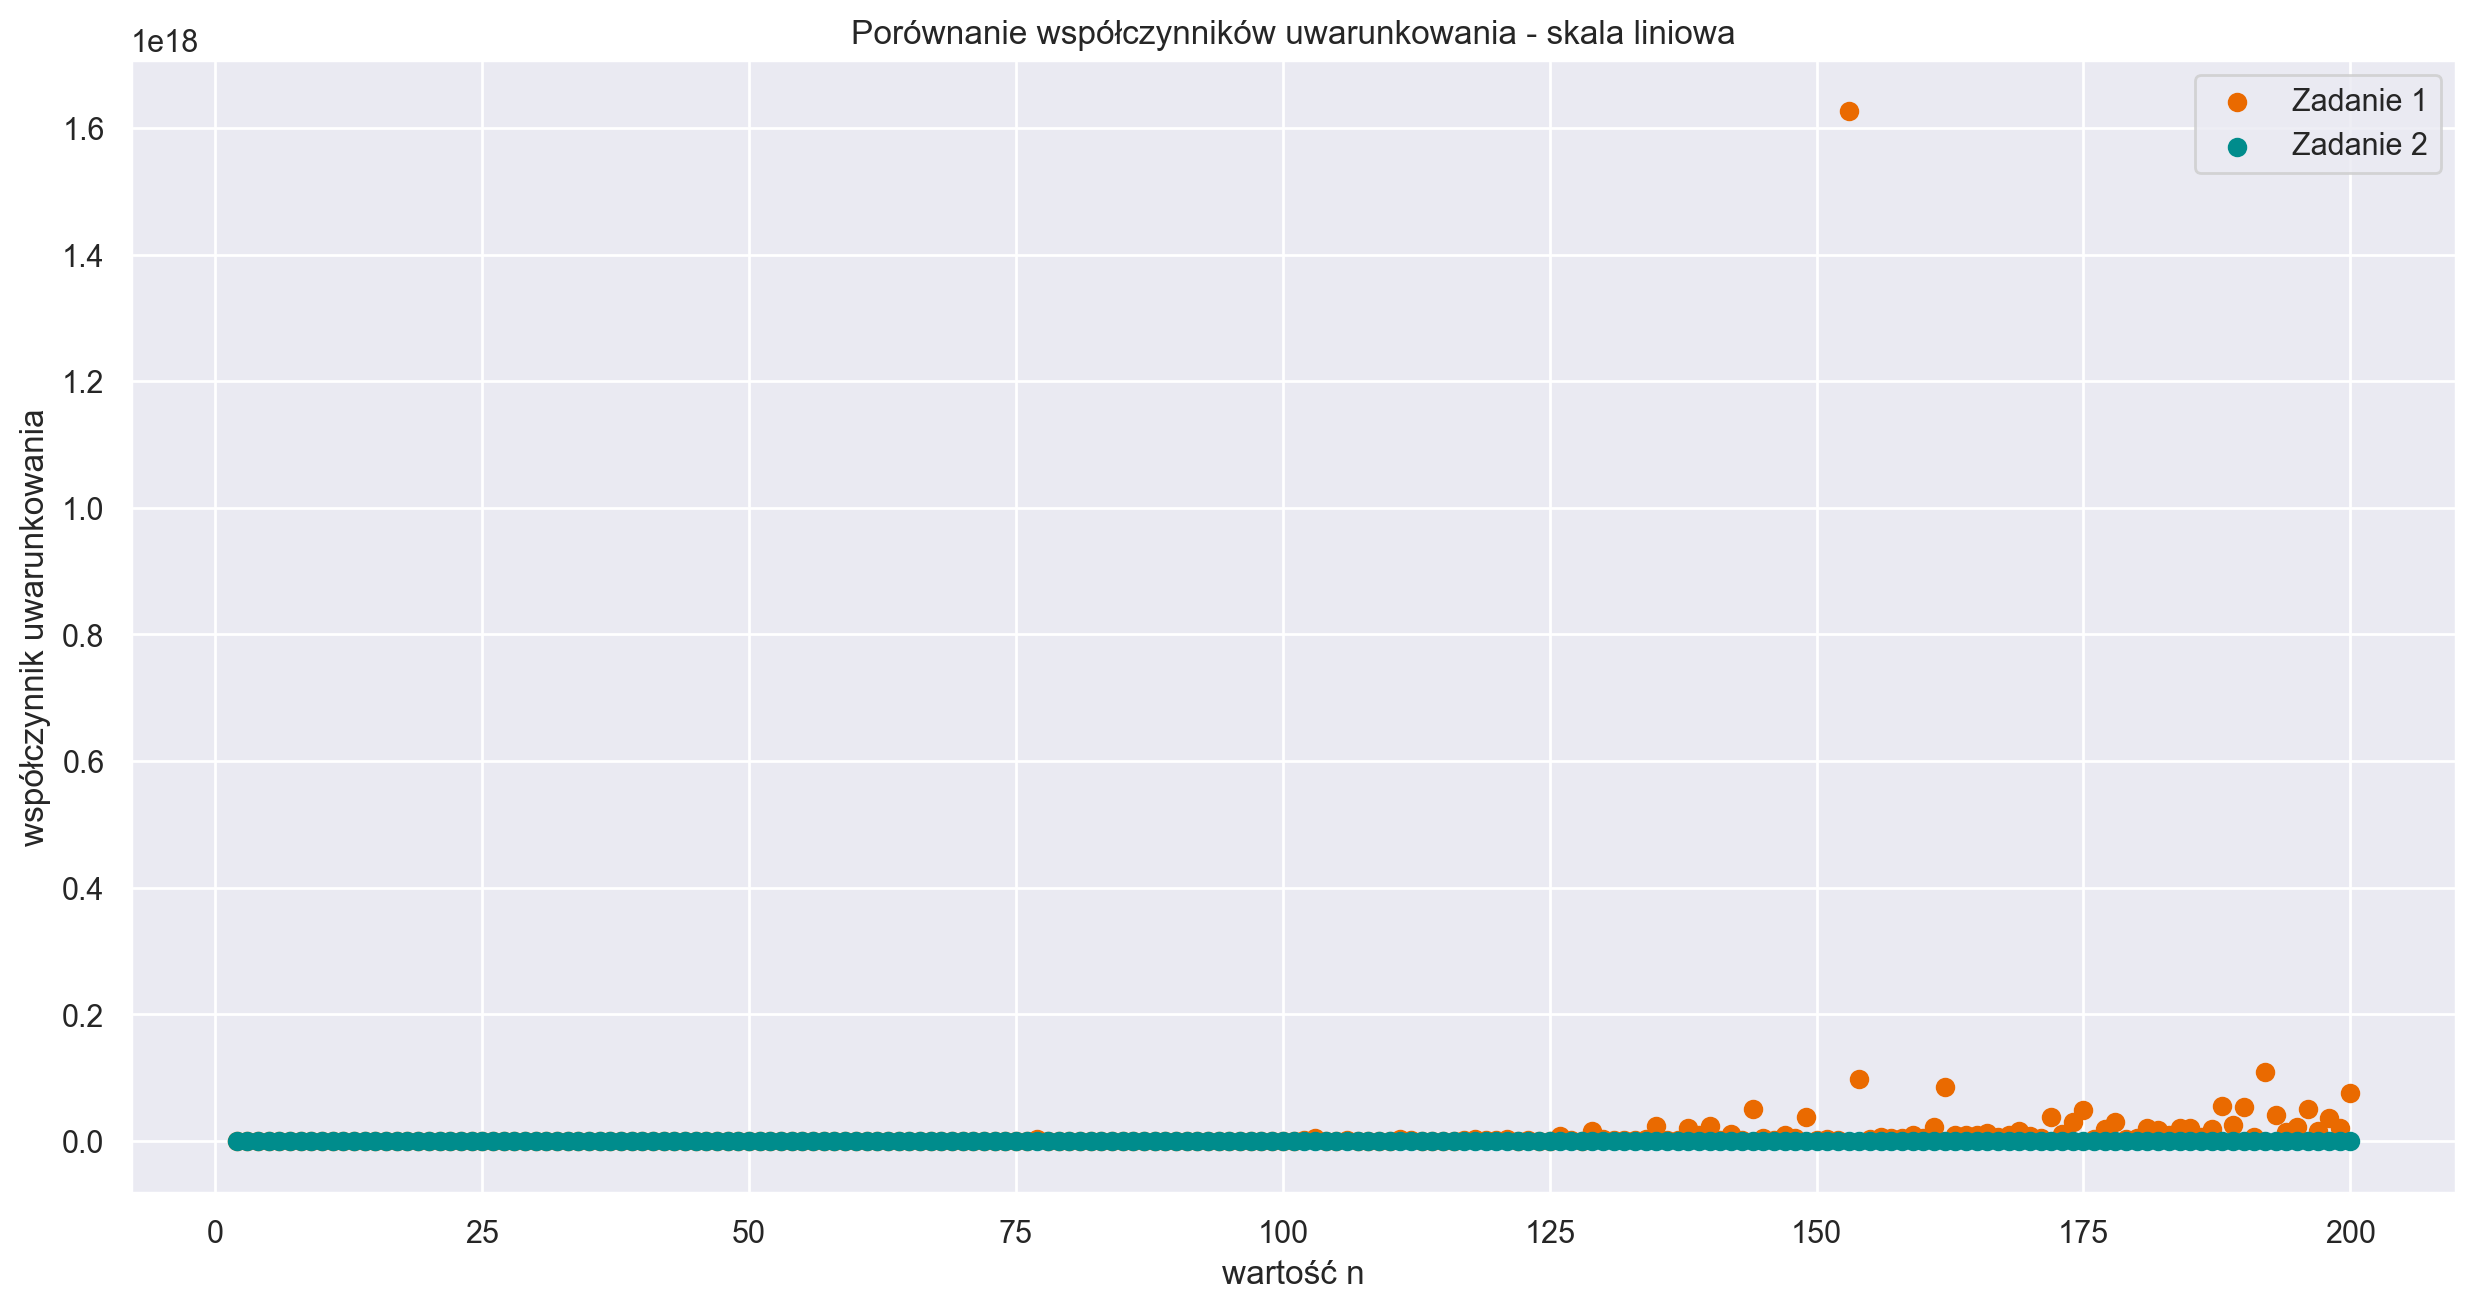

In [99]:
conditioning_factors_plot(cond_df, 'Porównanie współczynników uwarunkowania - skala liniowa')

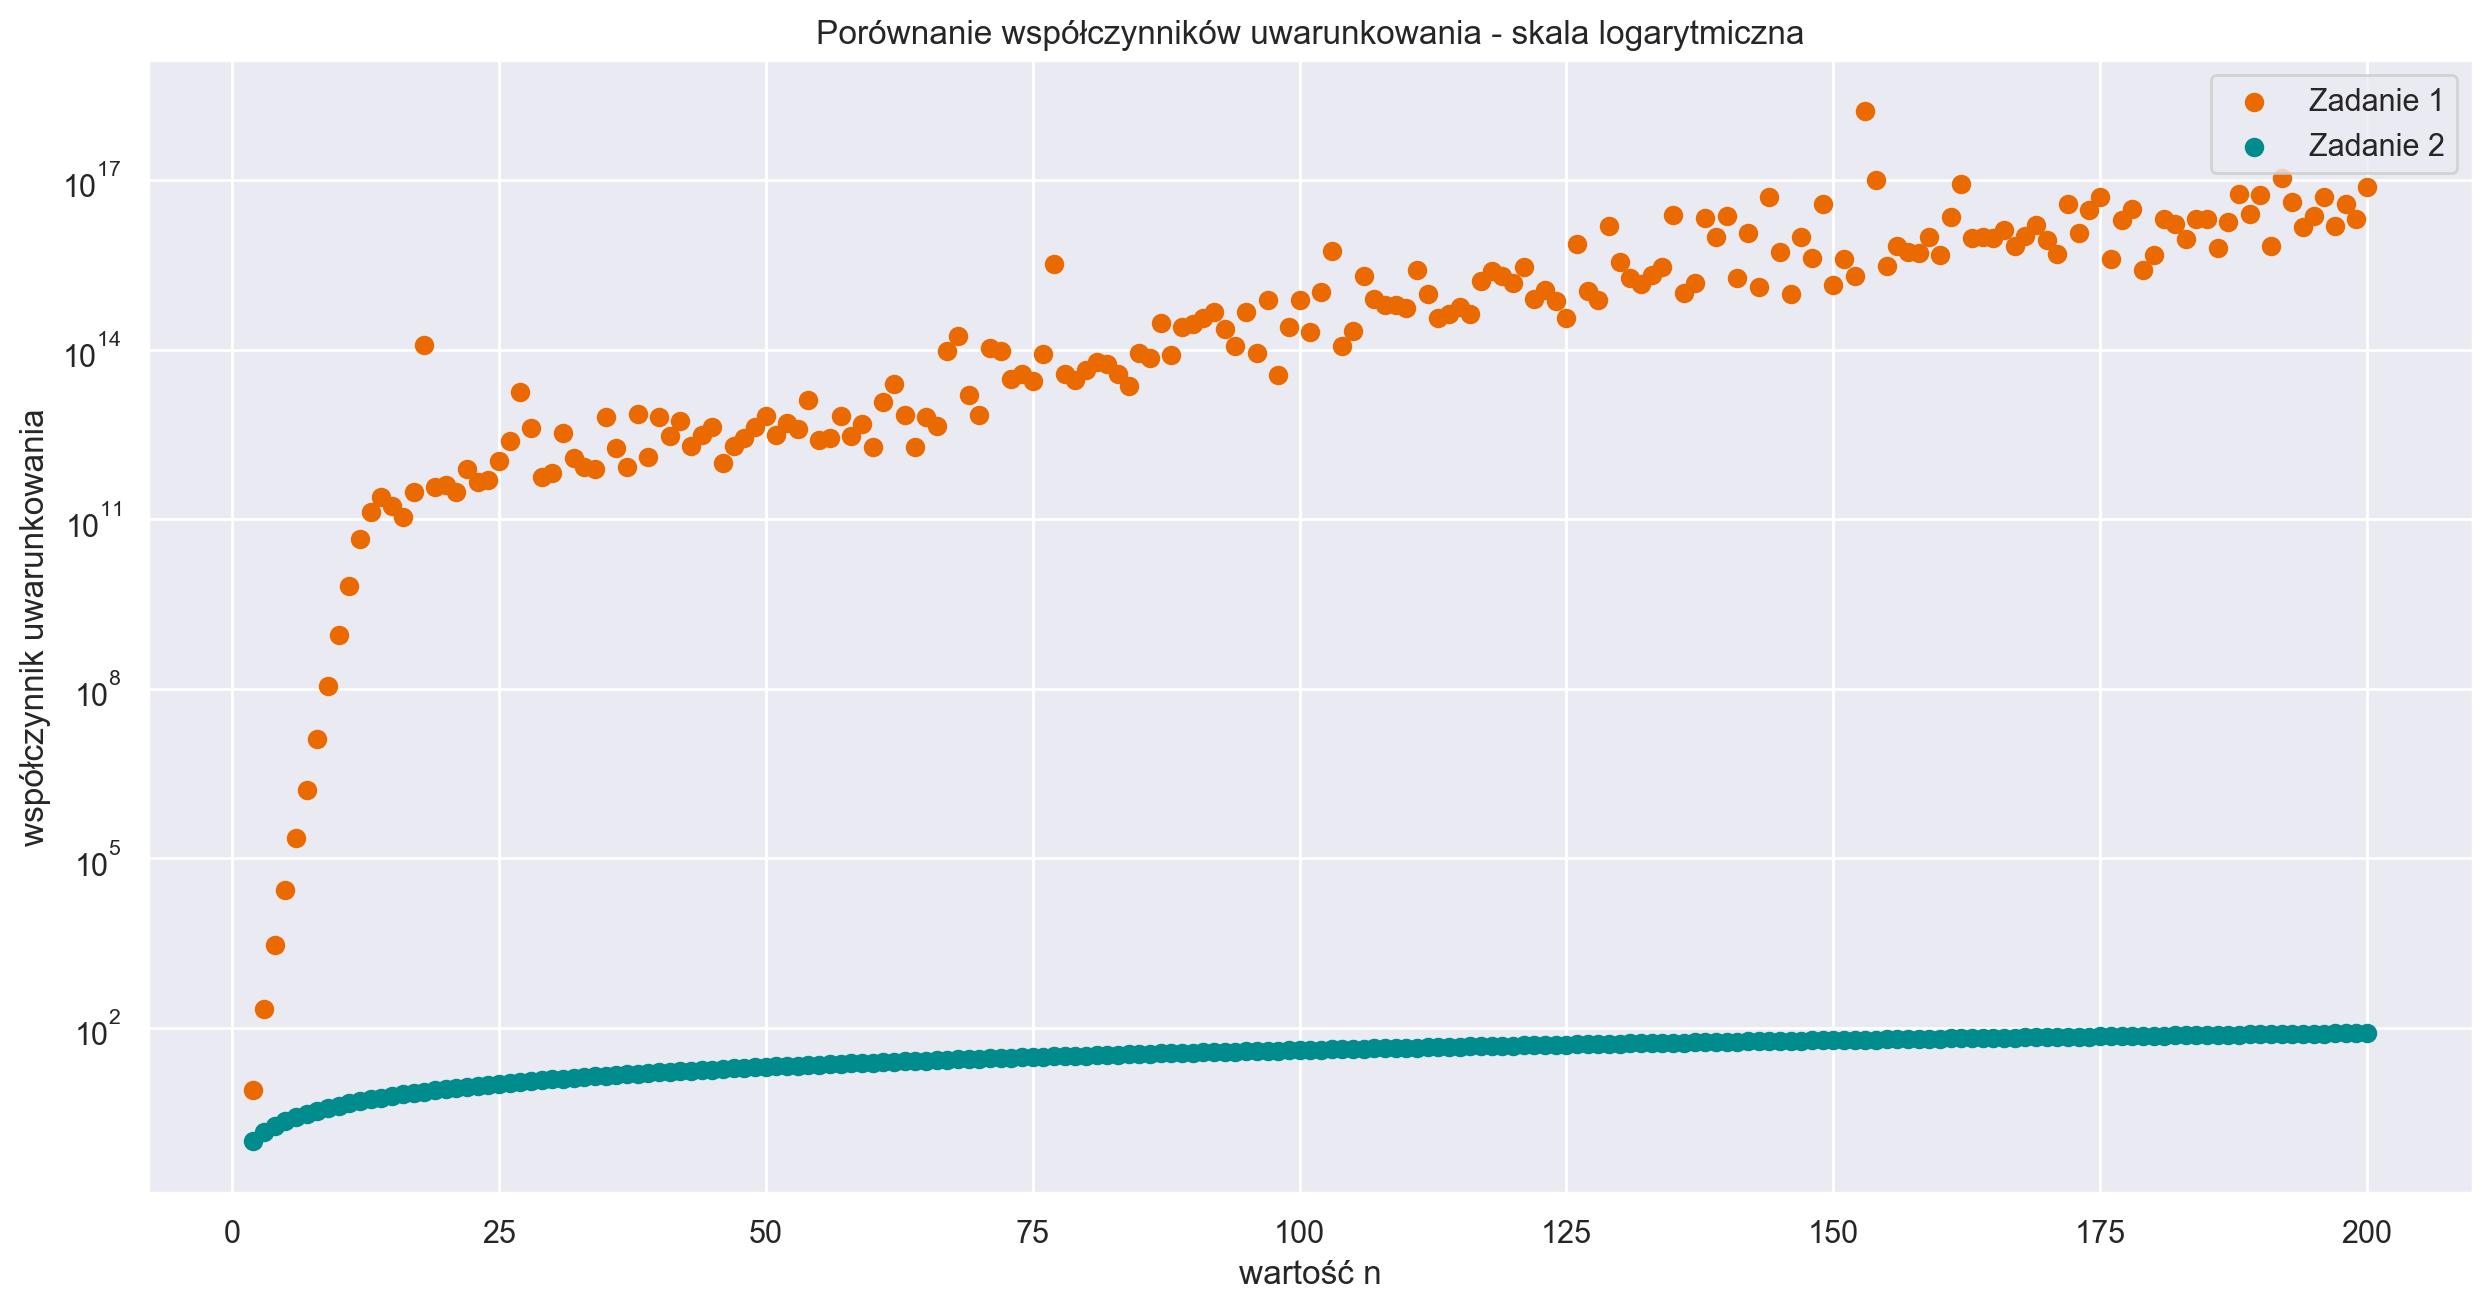

In [100]:
conditioning_factors_plot(cond_df, 'Porównanie współczynników uwarunkowania - skala logarytmiczna', 'log')